In [22]:
import os 
import random
import numpy as np
from PIL import Image

from datetime import datetime
import pickle
from tqdm import tqdm #loading bar  

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as ParentDataset

from torchvision import transforms
from torchvision.transforms import Compose

import sklearn.metrics

import segmentation_models_pytorch as smp #model we're using for now. 
import evaluateModel

from matplotlib import pyplot as plt

In [23]:
#Errors associated to potantial randomness / non-deterministic behaviour is a VERY common issue in PT. 
#Look at the following github discussion for more information: 
#https://github.com/pytorch/pytorch/issues/7068
#      sbelharbi commented on Apr 19, 2019

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [24]:
#This is related to the init function of the worker(s) to be fed to the DataLoader
def _init_fn(worker_id):
    np.random.seed(int(seed))

In [25]:
class TBI_dataset(ParentDataset): #Obtain the attributes of ParentDataset from torch.utils.data
#Finds Image and Label locations, creates random list of indicies for training / val / testing sets to be called
    def __init__(
        self,
        images_dir,
        labels_dir,
        train_size = 0.75, #fraction of total number of samples to be used in training set
        subset="train",
        transform = None, #base transformation is into Tensor. 
        random_sampling=True,
        seed=seed, #We'll get the same thing everytime if we keep using the same seed. 
    ):
        #filter and sort the list
        self.ImageIds = sorted(list(filter(('.DS_Store').__ne__,os.listdir(images_dir)))) 
        self.LabelIds = sorted(list(filter(('.DS_Store').__ne__,os.listdir(labels_dir))))
        
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ImageIds] #full_paths to slices
        self.labels_fps = [os.path.join(labels_dir, image_id) for image_id in self.LabelIds] #full_paths to labels
        
        if random_sampling == True:
            samples = list(range(0,len(self.images_fps))) #create a list of numbers
            random.seed(seed) #set the seed
            
            #random sample train_size amount and then do a train/validation split 
            indicies = random.sample(samples,round(train_size*len(samples)))
            self.val_indicies = indicies[0:round(len(indicies)*0.15)]
            self.train_indicies = indicies[round(len(indicies)*0.15) : len(indicies)]
            
            test_indicies = samples
            for j in sorted(indicies, reverse = True): #remove the train/val indicies from test set
                del test_indicies[j]
            
            #suffles without replacement. 
            self.test_indicies = random.sample(test_indicies, len(test_indicies)) 

        #We define a mapping to use when calling the Dataset loader based on the parameter "subset"
        if subset == "train":
            self.mapping = self.train_indicies
        elif subset == "val":
            self.mapping = self.val_indicies
        elif subset == "test":
            self.mapping = self.test_indicies
        else:
            print("subset parameter requires train, val, or test exactly.")
            
        self.transform = transform #trasform given by transform_function
            
    def __getitem__(self, ii): #ii is the index
        
        #Current implementations of transforms only use PIL images.
        #Apparently we can use np.array(Image.open(...)) to remove the error that happens each epoch
        image = Image.open(self.images_fps[self.mapping[ii]]) #open as PIL image. 
        label = Image.open(self.labels_fps[self.mapping[ii]])
         
        image = self.transform(image)
        label = self.transform(label)
             
        return image, label #, self.images_fps[self.mapping[ii]],self.labels_fps[self.mapping[ii]]
    
    def __len__(self):
        return len(self.mapping)
    
    
def datasets(images_dir, labels_dir, train_size, aug_angle, aug_scale, flip_prob):
    train = TBI_dataset(
        images_dir = images_dir,
        labels_dir = labels_dir,
        train_size = 0.75,
        subset = "train",
        transform = transform_function(degrees=aug_angle, scale=aug_scale, flip_prob=flip_prob),
    )
    valid = TBI_dataset(
        images_dir = images_dir,
        labels_dir = labels_dir,
        train_size = 0.75,
        subset = "val",
        transform = transform_function(degrees=aug_angle, scale=aug_scale, flip_prob=flip_prob),
    )
    
    test = TBI_dataset(
        images_dir = images_dir,
        labels_dir = labels_dir,
        train_size = 0.75,
        subset="test",
        transform = transform_function(degrees=0, scale = [1,1], flip_prob = 0), #make sure nothing changes. 
    )
    
    return train, valid, test

def transform_function(degrees,scale,flip_prob):
    transform_list = []
    
    transform_list.append(transforms.RandomAffine(degrees, scale = scale))
    transform_list.append(transforms.RandomHorizontalFlip(p=flip_prob))
    transform_list.append(transforms.Pad(37)) #all images should be 182x182 before padding. 
    transform_list.append(transforms.ToTensor())
    
    return Compose(transform_list)

def Weights(labels, device):
    #expects an [batch_size,c,n,n] input 
    
    weights = torch.rand(labels.shape) #create a random tensor of weight values. 
    weights = weights.to(device) #put everything onto the GPU. 
    
    for batch_num in range(0,labels.shape[0]):
        num_ones = torch.sum(labels[batch_num,0,:,:]);
        resolution = labels.shape[2] * labels.shape[3]
        num_zeros = resolution - num_ones 
        
        #https://discuss.pytorch.org/t/how-to-apply-a-weighted-bce-loss-to-an-imbalanced-dataset-what-will-the-weight-tensor-contain/56823/2
        #Weight for the positive class
        pos_weight = num_zeros / resolution #should be close to 1.
        neg_weight = 1 - pos_weight 
        
        #create 1s tensor, put to GPU.
        ones = torch.ones(labels.shape[2],labels.shape[3])
        ones = ones.to(device)
        
        weights[batch_num,0,:,:] = ones*neg_weight + labels[batch_num,0,:,:]*pos_weight
        
    #this keeps the clas imbalance in check
    return weights,pos_weight,neg_weight #should be a tensor. 
    

In [26]:
train_size = 0.75
batch_size = 12
EPOCHS = 40
lr = 0.0001
aug_angle = 25
aug_scale = [1,1.5]
flip_prob = 0.5
num_workers = 1
images_dir = "/home/mccrinbc/Registered_Brains_FA/normalized_slices"
labels_dir = "/home/mccrinbc/Registered_Brains_FA/slice_labels"

#images_dir = "/Users/brianmccrindle/Documents/Research/TBIFinder_Final/Registered_Brains_FA/test_slices"
#labels_dir = "/Users/brianmccrindle/Documents/Research/TBIFinder_Final/Registered_Brains_FA/test_labels"

#smp specific variables
ENCODER = 'resnet101'
aux_params=dict(
    pooling='avg',             # one of 'avg', 'max'
    dropout=0.5,               # dropout ratio, default is None
    #activation='softmax2d',    # activation function, default is None. This is the output activation. softmax2d specifies dim = 1 
    classes=1,                 # define number of output labels
)

#classes = 2 for the softmax transformation. 
model = smp.Unet(encoder_name = ENCODER, in_channels=1, classes = 1, aux_params = aux_params)

In [27]:
train_dataset, valid_dataset, test_dataset = datasets(images_dir, labels_dir, train_size, aug_angle, aug_scale, flip_prob)

In [28]:
class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

In [29]:
def train_validate(train_dataset, valid_dataset, lr):
    
    earlystop = False 
    
    if torch.cuda.is_available():
        dev ="cuda:2"
    else:
        dev = "cpu"
        
    dev = torch.device(dev)
    
    #this might break, remove worker_init_fn = _init_fn(num_workers)) if so
    train_loader = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = num_workers, worker_init_fn = _init_fn(num_workers))
    valid_loader = DataLoader(valid_dataset, batch_size, shuffle = True, num_workers = num_workers, worker_init_fn = _init_fn(num_workers))
    
    model.to(dev) #cast the model onto the device 
    optimizer = optim.Adam(model.parameters(), lr = lr) #learning rate should change 
    
    loss_function = torch.nn.BCELoss() #this takes in a weighted input 
    #loss_function = smp.utils.losses.DiceLoss()
    #loss_function = DiceLoss()
    #metrics = [smp.utils.metrics.IoU(threshold=0.5)]
    
    loss_train = []
    loss_valid = []
    epochLoss_train = []
    epochLoss_valid = []
        
    for epoch in range(EPOCHS):
        image_count = 0
        for phase in ["train","val"]:
            
            #This determines which portions of the model will have gradients turned off or on. 
            if phase == "train":
                model.train() #put into training mode
                loader = train_loader
            else:
                model.eval() #evaluation mode.
                loader = valid_loader
                  
            for ii, data in enumerate(loader): 
                
                brains = data[0] #[batch_size,channels,height,width] 
                labels = data[1]
                
                image_count += len(brains)
                print(epoch, phase, ii, image_count)
                
                brains,labels = brains.to(dev), labels.to(dev) #put the data onto the device
                predictions, single_class = model(brains) #single class is not a useful output. 
                
                predictions = torch.sigmoid(predictions) #using this so that the output is bounded [0,1]
                single_class = torch.sigmoid(single_class)
                
                weights = Weights(labels,dev) #generate the weights for each slice in the batch
                loss_function.pos_weight = weights                    
                
                #Implementing BCE Loss
                loss = loss_function(predictions, labels) #loss changes here. 
                
                if phase == "train":
                    #employ this so we don't get multiples in the same list. 
                    if (loss_valid and ii == 0): #if loss_valid is NOT empty AND it's the first time we see this
                        epochLoss_valid.append(loss_valid[-1]) #append the last value in the 
                        
                    model.zero_grad() #recommended way to perform validation
                    loss_train.append(loss.item())
                    loss.backward()
                    optimizer.step()
                    
                    print(f"Phase: {phase}. Epoch: {epoch}. Loss: {loss.item()}") 
               
                else:
                    if (loss_train and ii == 0):#if loss_valid is NOT empty AND it's the first time we see this
                        epochLoss_train.append(loss_train[-1]) #append the last value in the loss_train list.
                        
                    loss_valid.append(loss.item())
                    print(f"Phase: {phase}. Epoch: {epoch}. Loss: {loss.item()}") 
                    
                    #learning rate changes and early stopping
                    if epoch > 0:
                        if (epoch % 10) == 0: #if the epoch is divisable by 10
                            meanVal = np.mean(loss_valid[epoch - 10 : epoch])
                            if np.abs((meanVal - loss.item()) / meanVal) <= 0.05: #if the % difference is small
                                for param_group in optimizer.param_groups:
                                    print('Reducing the Learning Rate: ' )
                                    lr = lr * 0.1 #reduce the learning rate by a factor of 10. 
                                    print('Reducing the Learning Rate: ', lr )
                                    param_group['lr'] = lr
                        
                        if (epoch % 50) == 0:
                            meanVal = np.mean(loss_valid[epoch - 50 : epoch])
                            if np.abs((meanVal - loss.item()) / meanVal) <= 0.05:
                                earlystop = True 
               
                #Implementation of early stopping
                if earlystop == True:
                    date = datetime.now()
                    torch.save(model.state_dict(), os.path.join(os.getcwd(), "Registered_Brains_FA/models_saved", "TBI_model-epoch" + str(epoch) + '-' + str(date.date()) + '-' + str(date.hour) + '-' + str(date.minute) +"-EARLYSTOP.pt")) #save the model 
                    break
            else:
                continue
            break
        else:
            #save the model at the end of this epoch.
            #date = datetime.now()
            #torch.save(model.state_dict(), os.path.join(os.getcwd(), "Registered_Brains_FA/models_saved", "TBI_model-epoch" + str(epoch) + '-' + str(date.date()) + '-' + str(date.hour) + '-' + str(date.minute) + ".pt"))
            continue
        break
    
    #Need to add the last element from loss_valid to epochLoss_valid to equal the number of epochs. 
    epochLoss_valid.append(loss_valid[-1])
    return brains, labels, predictions, single_class, loss_train, loss_valid, epochLoss_train, epochLoss_valid, model.state_dict()


In [30]:
#This function expects singular images. 
#Also biased from high class imbalance. function currently not in use. 
def IoU(prediction, label):
    #Prediction IoU
    intersection = int(torch.sum(torch.mul(prediction,label)))
    union = int(torch.sum(prediction) + torch.sum(label)) - intersection
    IOU_predicted = intersection / (union + 0.0001) #for stability
    mean_IoU = IOU_predicted
    
    #Not including background IoU
    #Background IoU
    #all_zeros = (prediction + label) > 0 #before the inversion
    #intersection = int(torch.sum(~all_zeros))
    #union = int(torch.sum(~ (prediction > 0)) + torch.sum(~ (label > 0)) - intersection)
    #IOU_background = intersection / (union + 0.0001)
    
    #mean_IOU = (IOU_background + IOU_predicted)/2
    return mean_IoU

In [31]:
def testModel(test_dataset, modelPath, threshold): #model = the model class = smp.UNet()

    total_images = 0
    mean_IoUs = []
    CM_values = [0,0,0,0] #tp, fn, fp, tn
    model.load_state_dict(torch.load(modelPath))
    
    if torch.cuda.is_available():
        dev ="cuda:2"
    else:
        dev = "cpu"
        
    dev = torch.device(dev)
    model.to(dev) 
    model.eval() #evaluation mode to turn off the gradients / training. 
    
    #turn shuffle off 
    loader = DataLoader(test_dataset, batch_size = 12, shuffle = False, num_workers = num_workers)
    for ii, data in tqdm(enumerate(loader)):
        
        brains = data[0]
        labels = data[1]
        
        #move the data to the GPU 
        brains = brains.to(dev)
        labels = labels.to(dev)
        
        total_images += brains.shape[0] #this would be the same if we used labels or predictions. 
        #print(total_images)
        
        predictions, _ = model(brains)
        predictions = torch.sigmoid(predictions) 
        
        predictions_numpy = predictions.cpu().detach().numpy()
        labels_numpy = labels.cpu().detach().numpy()
        for j in range(predictions.shape[0]):
            #labels = [False, True] are needed to make sure we don't have errors with the shape of CM
            #mean_IoUs.append(IoU(predictions[j,0,:,:].cpu() > threshold, labels[j,0,:,:].cpu() > threshold)) #determine the mean IoU
            CM = sklearn.metrics.confusion_matrix(labels_numpy[j,0,:,:].ravel(), predictions_numpy[j,0,:,:].ravel() > threshold, labels = [True,False])
            try: 
                CM_values[0] = CM_values[0] + CM[0][0]
                CM_values[1] = CM_values[1] + CM[0][1]
                CM_values[2] = CM_values[2] + CM[1][0]
                CM_values[3] = CM_values[3] + CM[1][1]
            except:
                print("Error in Appending")
                return CM, CM_values
            
    del loader #delete loader, might be wrong to do this
    return np.divide(CM_values , (total_images*(256*256))) #, np.divide(np.sum(mean_IoUs), len(mean_IoUs))


In [32]:
#Training Cell 

brains, labels, predictions, single_class, loss_train, loss_valid, epochLoss_train, epochLoss_valid, model_state = train_validate(train_dataset, valid_dataset,lr)
    
date = datetime.now()
base = "results_TBI_model-End-" + str(date.date()) + '-' + str(date.hour)
folder_path = r'/home/mccrinbc/' + base
pkl_name = base + '.pkl'

pkl_location = os.path.join(folder_path, pkl_name)

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

torch.save(model_state, os.path.join(folder_path, base +".pt"))
    
# Saving the objects:
with open(pkl_location, 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([brains, labels, predictions, single_class, loss_train, loss_valid, epochLoss_train, epochLoss_valid, test_dataset], f)

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


0 train 0 12
Phase: train. Epoch: 0. Loss: 0.809135913848877
0 train 1 24
Phase: train. Epoch: 0. Loss: 0.7959729433059692
0 train 2 36
Phase: train. Epoch: 0. Loss: 0.7775373458862305
0 train 3 48
Phase: train. Epoch: 0. Loss: 0.7771362066268921
0 train 4 60
Phase: train. Epoch: 0. Loss: 0.7606479525566101
0 train 5 72
Phase: train. Epoch: 0. Loss: 0.7439953684806824
0 train 6 84
Phase: train. Epoch: 0. Loss: 0.7299100756645203
0 train 7 96
Phase: train. Epoch: 0. Loss: 0.7104331851005554
0 train 8 108
Phase: train. Epoch: 0. Loss: 0.7080222368240356
0 train 9 120
Phase: train. Epoch: 0. Loss: 0.6842791438102722
0 train 10 132
Phase: train. Epoch: 0. Loss: 0.6717615127563477
0 train 11 144
Phase: train. Epoch: 0. Loss: 0.6549856662750244
0 train 12 156
Phase: train. Epoch: 0. Loss: 0.6553171873092651
0 train 13 168
Phase: train. Epoch: 0. Loss: 0.6432138681411743
0 train 14 180
Phase: train. Epoch: 0. Loss: 0.6250741481781006
0 train 15 192
Phase: train. Epoch: 0. Loss: 0.619724452495

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


0 val 0 763
Phase: val. Epoch: 0. Loss: 3.688828229904175
0 val 1 775
Phase: val. Epoch: 0. Loss: 2.6063342094421387
0 val 2 787
Phase: val. Epoch: 0. Loss: 1.4232685565948486
0 val 3 799
Phase: val. Epoch: 0. Loss: 0.39841461181640625
0 val 4 811
Phase: val. Epoch: 0. Loss: 3.636025905609131
0 val 5 823
Phase: val. Epoch: 0. Loss: 3.570544719696045
0 val 6 835
Phase: val. Epoch: 0. Loss: 3.3412139415740967
0 val 7 847
Phase: val. Epoch: 0. Loss: 2.598459482192993
0 val 8 859
Phase: val. Epoch: 0. Loss: 1.7788007259368896
0 val 9 871
Phase: val. Epoch: 0. Loss: 1.7710613012313843
0 val 10 883
Phase: val. Epoch: 0. Loss: 0.5618190765380859
0 val 11 884
Phase: val. Epoch: 0. Loss: 6.9839701652526855


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


1 train 0 12
Phase: train. Epoch: 1. Loss: 0.39288419485092163
1 train 1 24
Phase: train. Epoch: 1. Loss: 0.405477374792099
1 train 2 36
Phase: train. Epoch: 1. Loss: 0.4035879969596863
1 train 3 48
Phase: train. Epoch: 1. Loss: 0.39612942934036255
1 train 4 60
Phase: train. Epoch: 1. Loss: 0.39571699500083923
1 train 5 72
Phase: train. Epoch: 1. Loss: 0.3789634704589844
1 train 6 84
Phase: train. Epoch: 1. Loss: 0.3879339098930359
1 train 7 96
Phase: train. Epoch: 1. Loss: 0.38172778487205505
1 train 8 108
Phase: train. Epoch: 1. Loss: 0.3781803548336029
1 train 9 120
Phase: train. Epoch: 1. Loss: 0.3827305734157562
1 train 10 132
Phase: train. Epoch: 1. Loss: 0.3775097727775574
1 train 11 144
Phase: train. Epoch: 1. Loss: 0.38631972670555115
1 train 12 156
Phase: train. Epoch: 1. Loss: 0.37073272466659546
1 train 13 168
Phase: train. Epoch: 1. Loss: 0.37123966217041016
1 train 14 180
Phase: train. Epoch: 1. Loss: 0.3661350905895233
1 train 15 192
Phase: train. Epoch: 1. Loss: 0.37304

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


1 val 0 763
Phase: val. Epoch: 1. Loss: 0.28892260789871216
1 val 1 775
Phase: val. Epoch: 1. Loss: 0.2794480323791504
1 val 2 787
Phase: val. Epoch: 1. Loss: 0.30442965030670166
1 val 3 799
Phase: val. Epoch: 1. Loss: 0.3163849115371704
1 val 4 811
Phase: val. Epoch: 1. Loss: 0.31842511892318726
1 val 5 823
Phase: val. Epoch: 1. Loss: 0.31515729427337646
1 val 6 835
Phase: val. Epoch: 1. Loss: 0.28369832038879395
1 val 7 847
Phase: val. Epoch: 1. Loss: 0.28520384430885315
1 val 8 859
Phase: val. Epoch: 1. Loss: 0.2994415760040283
1 val 9 871
Phase: val. Epoch: 1. Loss: 0.30277198553085327
1 val 10 883
Phase: val. Epoch: 1. Loss: 0.29461973905563354
1 val 11 884
Phase: val. Epoch: 1. Loss: 0.34238654375076294


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


2 train 0 12
Phase: train. Epoch: 2. Loss: 0.31052741408348083
2 train 1 24
Phase: train. Epoch: 2. Loss: 0.31100302934646606
2 train 2 36
Phase: train. Epoch: 2. Loss: 0.3032737672328949
2 train 3 48
Phase: train. Epoch: 2. Loss: 0.30351006984710693
2 train 4 60
Phase: train. Epoch: 2. Loss: 0.3013817071914673
2 train 5 72
Phase: train. Epoch: 2. Loss: 0.30433955788612366
2 train 6 84
Phase: train. Epoch: 2. Loss: 0.3072739541530609
2 train 7 96
Phase: train. Epoch: 2. Loss: 0.31620126962661743
2 train 8 108
Phase: train. Epoch: 2. Loss: 0.3130286633968353
2 train 9 120
Phase: train. Epoch: 2. Loss: 0.31778523325920105
2 train 10 132
Phase: train. Epoch: 2. Loss: 0.3163800835609436
2 train 11 144
Phase: train. Epoch: 2. Loss: 0.3087778091430664
2 train 12 156
Phase: train. Epoch: 2. Loss: 0.2930331826210022
2 train 13 168
Phase: train. Epoch: 2. Loss: 0.2903253436088562
2 train 14 180
Phase: train. Epoch: 2. Loss: 0.308625191450119
2 train 15 192
Phase: train. Epoch: 2. Loss: 0.314825

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


2 val 0 763
Phase: val. Epoch: 2. Loss: 0.24279314279556274
2 val 1 775
Phase: val. Epoch: 2. Loss: 0.23987016081809998
2 val 2 787
Phase: val. Epoch: 2. Loss: 0.4420188367366791
2 val 3 799
Phase: val. Epoch: 2. Loss: 0.2884567081928253
2 val 4 811
Phase: val. Epoch: 2. Loss: 0.2757360339164734
2 val 5 823
Phase: val. Epoch: 2. Loss: 0.4015953242778778
2 val 6 835
Phase: val. Epoch: 2. Loss: 0.38841018080711365
2 val 7 847
Phase: val. Epoch: 2. Loss: 0.28514882922172546
2 val 8 859
Phase: val. Epoch: 2. Loss: 0.24066118896007538
2 val 9 871
Phase: val. Epoch: 2. Loss: 0.2628377377986908
2 val 10 883
Phase: val. Epoch: 2. Loss: 0.24124698340892792
2 val 11 884
Phase: val. Epoch: 2. Loss: 0.2738380432128906


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


3 train 0 12
Phase: train. Epoch: 3. Loss: 0.2603372037410736
3 train 1 24
Phase: train. Epoch: 3. Loss: 0.2618139386177063
3 train 2 36
Phase: train. Epoch: 3. Loss: 0.24876508116722107
3 train 3 48
Phase: train. Epoch: 3. Loss: 0.268802285194397
3 train 4 60
Phase: train. Epoch: 3. Loss: 0.2607208490371704
3 train 5 72
Phase: train. Epoch: 3. Loss: 0.27295976877212524
3 train 6 84
Phase: train. Epoch: 3. Loss: 0.24803881347179413
3 train 7 96
Phase: train. Epoch: 3. Loss: 0.25064122676849365
3 train 8 108
Phase: train. Epoch: 3. Loss: 0.25251567363739014
3 train 9 120
Phase: train. Epoch: 3. Loss: 0.24573147296905518
3 train 10 132
Phase: train. Epoch: 3. Loss: 0.2511873245239258
3 train 11 144
Phase: train. Epoch: 3. Loss: 0.24434486031532288
3 train 12 156
Phase: train. Epoch: 3. Loss: 0.2642180621623993
3 train 13 168
Phase: train. Epoch: 3. Loss: 0.2509627044200897
3 train 14 180
Phase: train. Epoch: 3. Loss: 0.2418106496334076
3 train 15 192
Phase: train. Epoch: 3. Loss: 0.25452

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


3 val 0 763
Phase: val. Epoch: 3. Loss: 0.3580223321914673
3 val 1 775
Phase: val. Epoch: 3. Loss: 0.1995292752981186
3 val 2 787
Phase: val. Epoch: 3. Loss: 0.56354159116745
3 val 3 799
Phase: val. Epoch: 3. Loss: 0.20659703016281128
3 val 4 811
Phase: val. Epoch: 3. Loss: 0.7470240592956543
3 val 5 823
Phase: val. Epoch: 3. Loss: 0.5067341327667236
3 val 6 835
Phase: val. Epoch: 3. Loss: 0.2251521646976471
3 val 7 847
Phase: val. Epoch: 3. Loss: 0.5091248750686646
3 val 8 859
Phase: val. Epoch: 3. Loss: 0.21734389662742615
3 val 9 871
Phase: val. Epoch: 3. Loss: 0.8511940836906433
3 val 10 883
Phase: val. Epoch: 3. Loss: 0.3656238317489624
3 val 11 884
Phase: val. Epoch: 3. Loss: 0.16327360272407532


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


4 train 0 12
Phase: train. Epoch: 4. Loss: 0.22085264325141907
4 train 1 24
Phase: train. Epoch: 4. Loss: 0.20305579900741577
4 train 2 36
Phase: train. Epoch: 4. Loss: 0.20141355693340302
4 train 3 48
Phase: train. Epoch: 4. Loss: 0.21563363075256348
4 train 4 60
Phase: train. Epoch: 4. Loss: 0.2012724131345749
4 train 5 72
Phase: train. Epoch: 4. Loss: 0.19873778522014618
4 train 6 84
Phase: train. Epoch: 4. Loss: 0.22850379347801208
4 train 7 96
Phase: train. Epoch: 4. Loss: 0.20720987021923065
4 train 8 108
Phase: train. Epoch: 4. Loss: 0.2029062807559967
4 train 9 120
Phase: train. Epoch: 4. Loss: 0.2307034730911255
4 train 10 132
Phase: train. Epoch: 4. Loss: 0.21010610461235046
4 train 11 144
Phase: train. Epoch: 4. Loss: 0.19495031237602234
4 train 12 156
Phase: train. Epoch: 4. Loss: 0.2149289846420288
4 train 13 168
Phase: train. Epoch: 4. Loss: 0.22006754577159882
4 train 14 180
Phase: train. Epoch: 4. Loss: 0.20212897658348083
4 train 15 192
Phase: train. Epoch: 4. Loss: 0.

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


4 val 0 763
Phase: val. Epoch: 4. Loss: 0.17497079074382782
4 val 1 775
Phase: val. Epoch: 4. Loss: 0.19636467099189758
4 val 2 787
Phase: val. Epoch: 4. Loss: 0.17483572661876678
4 val 3 799
Phase: val. Epoch: 4. Loss: 0.17847001552581787
4 val 4 811
Phase: val. Epoch: 4. Loss: 0.16081836819648743
4 val 5 823
Phase: val. Epoch: 4. Loss: 0.18676108121871948
4 val 6 835
Phase: val. Epoch: 4. Loss: 0.1801227182149887
4 val 7 847
Phase: val. Epoch: 4. Loss: 0.16945433616638184
4 val 8 859
Phase: val. Epoch: 4. Loss: 0.19035908579826355
4 val 9 871
Phase: val. Epoch: 4. Loss: 0.18950533866882324
4 val 10 883
Phase: val. Epoch: 4. Loss: 0.16944757103919983
4 val 11 884
Phase: val. Epoch: 4. Loss: 0.16540606319904327


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


5 train 0 12
Phase: train. Epoch: 5. Loss: 0.17364203929901123
5 train 1 24
Phase: train. Epoch: 5. Loss: 0.17711329460144043
5 train 2 36
Phase: train. Epoch: 5. Loss: 0.2036442756652832
5 train 3 48
Phase: train. Epoch: 5. Loss: 0.19282619655132294
5 train 4 60
Phase: train. Epoch: 5. Loss: 0.17297837138175964
5 train 5 72
Phase: train. Epoch: 5. Loss: 0.20920249819755554
5 train 6 84
Phase: train. Epoch: 5. Loss: 0.17685970664024353
5 train 7 96
Phase: train. Epoch: 5. Loss: 0.17288926243782043
5 train 8 108
Phase: train. Epoch: 5. Loss: 0.16945046186447144
5 train 9 120
Phase: train. Epoch: 5. Loss: 0.15622755885124207
5 train 10 132
Phase: train. Epoch: 5. Loss: 0.17222940921783447
5 train 11 144
Phase: train. Epoch: 5. Loss: 0.16780231893062592
5 train 12 156
Phase: train. Epoch: 5. Loss: 0.18554536998271942
5 train 13 168
Phase: train. Epoch: 5. Loss: 0.18723586201667786
5 train 14 180
Phase: train. Epoch: 5. Loss: 0.20036177337169647
5 train 15 192
Phase: train. Epoch: 5. Loss:

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


5 val 0 763
Phase: val. Epoch: 5. Loss: 0.17333118617534637
5 val 1 775
Phase: val. Epoch: 5. Loss: 0.17721830308437347
5 val 2 787
Phase: val. Epoch: 5. Loss: 0.14084818959236145
5 val 3 799
Phase: val. Epoch: 5. Loss: 0.16752475500106812
5 val 4 811
Phase: val. Epoch: 5. Loss: 0.16542145609855652
5 val 5 823
Phase: val. Epoch: 5. Loss: 0.16705845296382904
5 val 6 835
Phase: val. Epoch: 5. Loss: 0.15215648710727692
5 val 7 847
Phase: val. Epoch: 5. Loss: 0.17275479435920715
5 val 8 859
Phase: val. Epoch: 5. Loss: 0.16900449991226196
5 val 9 871
Phase: val. Epoch: 5. Loss: 0.17304269969463348
5 val 10 883
Phase: val. Epoch: 5. Loss: 0.16726788878440857
5 val 11 884
Phase: val. Epoch: 5. Loss: 0.1761484444141388


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


6 train 0 12
Phase: train. Epoch: 6. Loss: 0.16919660568237305
6 train 1 24
Phase: train. Epoch: 6. Loss: 0.15491530299186707
6 train 2 36
Phase: train. Epoch: 6. Loss: 0.1513829231262207
6 train 3 48
Phase: train. Epoch: 6. Loss: 0.14699923992156982
6 train 4 60
Phase: train. Epoch: 6. Loss: 0.15251626074314117
6 train 5 72
Phase: train. Epoch: 6. Loss: 0.14109812676906586
6 train 6 84
Phase: train. Epoch: 6. Loss: 0.15902936458587646
6 train 7 96
Phase: train. Epoch: 6. Loss: 0.16808795928955078
6 train 8 108
Phase: train. Epoch: 6. Loss: 0.18084117770195007
6 train 9 120
Phase: train. Epoch: 6. Loss: 0.1462448537349701
6 train 10 132
Phase: train. Epoch: 6. Loss: 0.14565065503120422
6 train 11 144
Phase: train. Epoch: 6. Loss: 0.15326079726219177
6 train 12 156
Phase: train. Epoch: 6. Loss: 0.15791261196136475
6 train 13 168
Phase: train. Epoch: 6. Loss: 0.180855393409729
6 train 14 180
Phase: train. Epoch: 6. Loss: 0.15949131548404694
6 train 15 192
Phase: train. Epoch: 6. Loss: 0.

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


6 val 0 763
Phase: val. Epoch: 6. Loss: 0.16333884000778198
6 val 1 775
Phase: val. Epoch: 6. Loss: 0.16347470879554749
6 val 2 787
Phase: val. Epoch: 6. Loss: 0.1419638693332672
6 val 3 799
Phase: val. Epoch: 6. Loss: 0.16290345788002014
6 val 4 811
Phase: val. Epoch: 6. Loss: 0.1469484269618988
6 val 5 823
Phase: val. Epoch: 6. Loss: 0.1597597301006317
6 val 6 835
Phase: val. Epoch: 6. Loss: 0.193728968501091
6 val 7 847
Phase: val. Epoch: 6. Loss: 0.13254761695861816
6 val 8 859
Phase: val. Epoch: 6. Loss: 0.19803354144096375
6 val 9 871
Phase: val. Epoch: 6. Loss: 0.1712542027235031
6 val 10 883
Phase: val. Epoch: 6. Loss: 0.14505690336227417
6 val 11 884
Phase: val. Epoch: 6. Loss: 0.08409103751182556


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


7 train 0 12
Phase: train. Epoch: 7. Loss: 0.13662771880626678
7 train 1 24
Phase: train. Epoch: 7. Loss: 0.16302303969860077
7 train 2 36
Phase: train. Epoch: 7. Loss: 0.14604465663433075
7 train 3 48
Phase: train. Epoch: 7. Loss: 0.16603228449821472
7 train 4 60
Phase: train. Epoch: 7. Loss: 0.14503304660320282
7 train 5 72
Phase: train. Epoch: 7. Loss: 0.15844188630580902
7 train 6 84
Phase: train. Epoch: 7. Loss: 0.1309242695569992
7 train 7 96
Phase: train. Epoch: 7. Loss: 0.13449634611606598
7 train 8 108
Phase: train. Epoch: 7. Loss: 0.14830005168914795
7 train 9 120
Phase: train. Epoch: 7. Loss: 0.14433553814888
7 train 10 132
Phase: train. Epoch: 7. Loss: 0.12279602140188217
7 train 11 144
Phase: train. Epoch: 7. Loss: 0.1563776582479477
7 train 12 156
Phase: train. Epoch: 7. Loss: 0.13323521614074707
7 train 13 168
Phase: train. Epoch: 7. Loss: 0.1350366324186325
7 train 14 180
Phase: train. Epoch: 7. Loss: 0.1468772143125534
7 train 15 192
Phase: train. Epoch: 7. Loss: 0.153

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


7 val 0 763
Phase: val. Epoch: 7. Loss: 0.13100187480449677
7 val 1 775
Phase: val. Epoch: 7. Loss: 0.10321541875600815
7 val 2 787
Phase: val. Epoch: 7. Loss: 0.10301943868398666
7 val 3 799
Phase: val. Epoch: 7. Loss: 0.13927806913852692
7 val 4 811
Phase: val. Epoch: 7. Loss: 0.12957227230072021
7 val 5 823
Phase: val. Epoch: 7. Loss: 0.12120857834815979
7 val 6 835
Phase: val. Epoch: 7. Loss: 0.13372552394866943
7 val 7 847
Phase: val. Epoch: 7. Loss: 0.14862841367721558
7 val 8 859
Phase: val. Epoch: 7. Loss: 0.1179986447095871
7 val 9 871
Phase: val. Epoch: 7. Loss: 0.15417566895484924
7 val 10 883
Phase: val. Epoch: 7. Loss: 0.1242295503616333
7 val 11 884
Phase: val. Epoch: 7. Loss: 0.08994942903518677


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


8 train 0 12
Phase: train. Epoch: 8. Loss: 0.11510312557220459
8 train 1 24
Phase: train. Epoch: 8. Loss: 0.14437901973724365
8 train 2 36
Phase: train. Epoch: 8. Loss: 0.12212447822093964
8 train 3 48
Phase: train. Epoch: 8. Loss: 0.12368820607662201
8 train 4 60
Phase: train. Epoch: 8. Loss: 0.1356855034828186
8 train 5 72
Phase: train. Epoch: 8. Loss: 0.11792951822280884
8 train 6 84
Phase: train. Epoch: 8. Loss: 0.12045037746429443
8 train 7 96
Phase: train. Epoch: 8. Loss: 0.1106354296207428
8 train 8 108
Phase: train. Epoch: 8. Loss: 0.12353983521461487
8 train 9 120
Phase: train. Epoch: 8. Loss: 0.10782575607299805
8 train 10 132
Phase: train. Epoch: 8. Loss: 0.15534228086471558
8 train 11 144
Phase: train. Epoch: 8. Loss: 0.12119933217763901
8 train 12 156
Phase: train. Epoch: 8. Loss: 0.13517236709594727
8 train 13 168
Phase: train. Epoch: 8. Loss: 0.1453050822019577
8 train 14 180
Phase: train. Epoch: 8. Loss: 0.14244624972343445
8 train 15 192
Phase: train. Epoch: 8. Loss: 0

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


8 val 0 763
Phase: val. Epoch: 8. Loss: 0.11584361642599106
8 val 1 775
Phase: val. Epoch: 8. Loss: 0.11889199912548065
8 val 2 787
Phase: val. Epoch: 8. Loss: 0.11850309371948242
8 val 3 799
Phase: val. Epoch: 8. Loss: 0.1348220556974411
8 val 4 811
Phase: val. Epoch: 8. Loss: 0.12245410680770874
8 val 5 823
Phase: val. Epoch: 8. Loss: 0.12325267493724823
8 val 6 835
Phase: val. Epoch: 8. Loss: 0.11722676455974579
8 val 7 847
Phase: val. Epoch: 8. Loss: 0.14974379539489746
8 val 8 859
Phase: val. Epoch: 8. Loss: 0.12867829203605652
8 val 9 871
Phase: val. Epoch: 8. Loss: 0.11773707717657089
8 val 10 883
Phase: val. Epoch: 8. Loss: 0.12392841279506683
8 val 11 884
Phase: val. Epoch: 8. Loss: 0.07170455157756805


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


9 train 0 12
Phase: train. Epoch: 9. Loss: 0.10379289090633392
9 train 1 24
Phase: train. Epoch: 9. Loss: 0.12130873650312424
9 train 2 36
Phase: train. Epoch: 9. Loss: 0.10918091237545013
9 train 3 48
Phase: train. Epoch: 9. Loss: 0.140952467918396
9 train 4 60
Phase: train. Epoch: 9. Loss: 0.1316889226436615
9 train 5 72
Phase: train. Epoch: 9. Loss: 0.11930148303508759
9 train 6 84
Phase: train. Epoch: 9. Loss: 0.11948122829198837
9 train 7 96
Phase: train. Epoch: 9. Loss: 0.09868989884853363
9 train 8 108
Phase: train. Epoch: 9. Loss: 0.14794233441352844
9 train 9 120
Phase: train. Epoch: 9. Loss: 0.1198950931429863
9 train 10 132
Phase: train. Epoch: 9. Loss: 0.11037290096282959
9 train 11 144
Phase: train. Epoch: 9. Loss: 0.10789804905653
9 train 12 156
Phase: train. Epoch: 9. Loss: 0.14186209440231323
9 train 13 168
Phase: train. Epoch: 9. Loss: 0.11748576164245605
9 train 14 180
Phase: train. Epoch: 9. Loss: 0.1131645068526268
9 train 15 192
Phase: train. Epoch: 9. Loss: 0.1292

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


9 val 0 763
Phase: val. Epoch: 9. Loss: 0.09966248273849487
9 val 1 775
Phase: val. Epoch: 9. Loss: 0.101407989859581
9 val 2 787
Phase: val. Epoch: 9. Loss: 0.08956711739301682
9 val 3 799
Phase: val. Epoch: 9. Loss: 0.09517689049243927
9 val 4 811
Phase: val. Epoch: 9. Loss: 0.10507059097290039
9 val 5 823
Phase: val. Epoch: 9. Loss: 0.1136472225189209
9 val 6 835
Phase: val. Epoch: 9. Loss: 0.14514771103858948
9 val 7 847
Phase: val. Epoch: 9. Loss: 0.12439560890197754
9 val 8 859
Phase: val. Epoch: 9. Loss: 0.1152002140879631
9 val 9 871
Phase: val. Epoch: 9. Loss: 0.10789042711257935
9 val 10 883
Phase: val. Epoch: 9. Loss: 0.11910931766033173
9 val 11 884
Phase: val. Epoch: 9. Loss: 0.0658072978258133


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


10 train 0 12
Phase: train. Epoch: 10. Loss: 0.1125994324684143
10 train 1 24
Phase: train. Epoch: 10. Loss: 0.11534340679645538
10 train 2 36
Phase: train. Epoch: 10. Loss: 0.12203370779752731
10 train 3 48
Phase: train. Epoch: 10. Loss: 0.11286874115467072
10 train 4 60
Phase: train. Epoch: 10. Loss: 0.09653976559638977
10 train 5 72
Phase: train. Epoch: 10. Loss: 0.13931632041931152
10 train 6 84
Phase: train. Epoch: 10. Loss: 0.10889574885368347
10 train 7 96
Phase: train. Epoch: 10. Loss: 0.09993259608745575
10 train 8 108
Phase: train. Epoch: 10. Loss: 0.13546209037303925
10 train 9 120
Phase: train. Epoch: 10. Loss: 0.11119602620601654
10 train 10 132
Phase: train. Epoch: 10. Loss: 0.11163991689682007
10 train 11 144
Phase: train. Epoch: 10. Loss: 0.10229694098234177
10 train 12 156
Phase: train. Epoch: 10. Loss: 0.0904606431722641
10 train 13 168
Phase: train. Epoch: 10. Loss: 0.10427556931972504
10 train 14 180
Phase: train. Epoch: 10. Loss: 0.1165749654173851
10 train 15 192


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


10 val 0 763
Phase: val. Epoch: 10. Loss: 0.08602483570575714
10 val 1 775
Phase: val. Epoch: 10. Loss: 0.09360267221927643
10 val 2 787
Phase: val. Epoch: 10. Loss: 0.10620835423469543
10 val 3 799
Phase: val. Epoch: 10. Loss: 0.0629686713218689
10 val 4 811
Phase: val. Epoch: 10. Loss: 0.13068047165870667
10 val 5 823
Phase: val. Epoch: 10. Loss: 0.10840360820293427
10 val 6 835
Phase: val. Epoch: 10. Loss: 0.10685273259878159
10 val 7 847
Phase: val. Epoch: 10. Loss: 0.08893515914678574
10 val 8 859
Phase: val. Epoch: 10. Loss: 0.1048811599612236
10 val 9 871
Phase: val. Epoch: 10. Loss: 0.11091836541891098
10 val 10 883
Phase: val. Epoch: 10. Loss: 0.1087314635515213
10 val 11 884
Phase: val. Epoch: 10. Loss: 0.04644937068223953


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


11 train 0 12
Phase: train. Epoch: 11. Loss: 0.10168125480413437
11 train 1 24
Phase: train. Epoch: 11. Loss: 0.09474669396877289
11 train 2 36
Phase: train. Epoch: 11. Loss: 0.10431142896413803
11 train 3 48
Phase: train. Epoch: 11. Loss: 0.08991675078868866
11 train 4 60
Phase: train. Epoch: 11. Loss: 0.08832018822431564
11 train 5 72
Phase: train. Epoch: 11. Loss: 0.10086695849895477
11 train 6 84
Phase: train. Epoch: 11. Loss: 0.1005907878279686
11 train 7 96
Phase: train. Epoch: 11. Loss: 0.1050894483923912
11 train 8 108
Phase: train. Epoch: 11. Loss: 0.08450286090373993
11 train 9 120
Phase: train. Epoch: 11. Loss: 0.09417901933193207
11 train 10 132
Phase: train. Epoch: 11. Loss: 0.12921693921089172
11 train 11 144
Phase: train. Epoch: 11. Loss: 0.10883884876966476
11 train 12 156
Phase: train. Epoch: 11. Loss: 0.1418062448501587
11 train 13 168
Phase: train. Epoch: 11. Loss: 0.10491349548101425
11 train 14 180
Phase: train. Epoch: 11. Loss: 0.1128590926527977
11 train 15 192
P

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


11 val 0 763
Phase: val. Epoch: 11. Loss: 0.09140253067016602
11 val 1 775
Phase: val. Epoch: 11. Loss: 0.10184051841497421
11 val 2 787
Phase: val. Epoch: 11. Loss: 0.10289424657821655
11 val 3 799
Phase: val. Epoch: 11. Loss: 0.06622670590877533
11 val 4 811
Phase: val. Epoch: 11. Loss: 0.08771219849586487
11 val 5 823
Phase: val. Epoch: 11. Loss: 0.09580667316913605
11 val 6 835
Phase: val. Epoch: 11. Loss: 0.06971687823534012
11 val 7 847
Phase: val. Epoch: 11. Loss: 0.08589702844619751
11 val 8 859
Phase: val. Epoch: 11. Loss: 0.10403843969106674
11 val 9 871
Phase: val. Epoch: 11. Loss: 0.12856607139110565
11 val 10 883
Phase: val. Epoch: 11. Loss: 0.11423234641551971
11 val 11 884
Phase: val. Epoch: 11. Loss: 0.08279120177030563


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


12 train 0 12
Phase: train. Epoch: 12. Loss: 0.0895499587059021
12 train 1 24
Phase: train. Epoch: 12. Loss: 0.10167211294174194
12 train 2 36
Phase: train. Epoch: 12. Loss: 0.0858389362692833
12 train 3 48
Phase: train. Epoch: 12. Loss: 0.09931176900863647
12 train 4 60
Phase: train. Epoch: 12. Loss: 0.11198519915342331
12 train 5 72
Phase: train. Epoch: 12. Loss: 0.08644966781139374
12 train 6 84
Phase: train. Epoch: 12. Loss: 0.08029220998287201
12 train 7 96
Phase: train. Epoch: 12. Loss: 0.09290315955877304
12 train 8 108
Phase: train. Epoch: 12. Loss: 0.09210746735334396
12 train 9 120
Phase: train. Epoch: 12. Loss: 0.07742449641227722
12 train 10 132
Phase: train. Epoch: 12. Loss: 0.0887192115187645
12 train 11 144
Phase: train. Epoch: 12. Loss: 0.0904126986861229
12 train 12 156
Phase: train. Epoch: 12. Loss: 0.08768313378095627
12 train 13 168
Phase: train. Epoch: 12. Loss: 0.11336483806371689
12 train 14 180
Phase: train. Epoch: 12. Loss: 0.09361064434051514
12 train 15 192
P

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


12 val 0 763
Phase: val. Epoch: 12. Loss: 0.09061692655086517
12 val 1 775
Phase: val. Epoch: 12. Loss: 0.07744497060775757
12 val 2 787
Phase: val. Epoch: 12. Loss: 0.1415649652481079
12 val 3 799
Phase: val. Epoch: 12. Loss: 0.08862368762493134
12 val 4 811
Phase: val. Epoch: 12. Loss: 0.0988965854048729
12 val 5 823
Phase: val. Epoch: 12. Loss: 0.0760745033621788
12 val 6 835
Phase: val. Epoch: 12. Loss: 0.11252637207508087
12 val 7 847
Phase: val. Epoch: 12. Loss: 0.0916057750582695
12 val 8 859
Phase: val. Epoch: 12. Loss: 0.06862765550613403
12 val 9 871
Phase: val. Epoch: 12. Loss: 0.13441398739814758
12 val 10 883
Phase: val. Epoch: 12. Loss: 0.09146425127983093
12 val 11 884
Phase: val. Epoch: 12. Loss: 0.06912694126367569


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


13 train 0 12
Phase: train. Epoch: 13. Loss: 0.09192948788404465
13 train 1 24
Phase: train. Epoch: 13. Loss: 0.11142909526824951
13 train 2 36
Phase: train. Epoch: 13. Loss: 0.11311542987823486
13 train 3 48
Phase: train. Epoch: 13. Loss: 0.09430515766143799
13 train 4 60
Phase: train. Epoch: 13. Loss: 0.07618671655654907
13 train 5 72
Phase: train. Epoch: 13. Loss: 0.08864250034093857
13 train 6 84
Phase: train. Epoch: 13. Loss: 0.10136650502681732
13 train 7 96
Phase: train. Epoch: 13. Loss: 0.08958280086517334
13 train 8 108
Phase: train. Epoch: 13. Loss: 0.08505465090274811
13 train 9 120
Phase: train. Epoch: 13. Loss: 0.10502378642559052
13 train 10 132
Phase: train. Epoch: 13. Loss: 0.08334462344646454
13 train 11 144
Phase: train. Epoch: 13. Loss: 0.08895441144704819
13 train 12 156
Phase: train. Epoch: 13. Loss: 0.10537608712911606
13 train 13 168
Phase: train. Epoch: 13. Loss: 0.07895445078611374
13 train 14 180
Phase: train. Epoch: 13. Loss: 0.08749787509441376
13 train 15 1

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


13 val 0 763
Phase: val. Epoch: 13. Loss: 0.0724116638302803
13 val 1 775
Phase: val. Epoch: 13. Loss: 0.06201430782675743
13 val 2 787
Phase: val. Epoch: 13. Loss: 0.07725366950035095
13 val 3 799
Phase: val. Epoch: 13. Loss: 0.1015995666384697
13 val 4 811
Phase: val. Epoch: 13. Loss: 0.06994467228651047
13 val 5 823
Phase: val. Epoch: 13. Loss: 0.08866328001022339
13 val 6 835
Phase: val. Epoch: 13. Loss: 0.09298084676265717
13 val 7 847
Phase: val. Epoch: 13. Loss: 0.10270529985427856
13 val 8 859
Phase: val. Epoch: 13. Loss: 0.10116982460021973
13 val 9 871
Phase: val. Epoch: 13. Loss: 0.08130866289138794
13 val 10 883
Phase: val. Epoch: 13. Loss: 0.08469723165035248
13 val 11 884
Phase: val. Epoch: 13. Loss: 0.06149495393037796


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


14 train 0 12
Phase: train. Epoch: 14. Loss: 0.08572165668010712
14 train 1 24
Phase: train. Epoch: 14. Loss: 0.08979557454586029
14 train 2 36
Phase: train. Epoch: 14. Loss: 0.09682323038578033
14 train 3 48
Phase: train. Epoch: 14. Loss: 0.12203707545995712
14 train 4 60
Phase: train. Epoch: 14. Loss: 0.10285787284374237
14 train 5 72
Phase: train. Epoch: 14. Loss: 0.06787452101707458
14 train 6 84
Phase: train. Epoch: 14. Loss: 0.07255128026008606
14 train 7 96
Phase: train. Epoch: 14. Loss: 0.09470170736312866
14 train 8 108
Phase: train. Epoch: 14. Loss: 0.07267343252897263
14 train 9 120
Phase: train. Epoch: 14. Loss: 0.09810610860586166
14 train 10 132
Phase: train. Epoch: 14. Loss: 0.08668329566717148
14 train 11 144
Phase: train. Epoch: 14. Loss: 0.08009093999862671
14 train 12 156
Phase: train. Epoch: 14. Loss: 0.0863836333155632
14 train 13 168
Phase: train. Epoch: 14. Loss: 0.07389267534017563
14 train 14 180
Phase: train. Epoch: 14. Loss: 0.13034145534038544
14 train 15 19

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


14 val 0 763
Phase: val. Epoch: 14. Loss: 0.06982870399951935
14 val 1 775
Phase: val. Epoch: 14. Loss: 0.06956671178340912
14 val 2 787
Phase: val. Epoch: 14. Loss: 0.07658490538597107
14 val 3 799
Phase: val. Epoch: 14. Loss: 0.08019419759511948
14 val 4 811
Phase: val. Epoch: 14. Loss: 0.07980561256408691
14 val 5 823
Phase: val. Epoch: 14. Loss: 0.06403782218694687
14 val 6 835
Phase: val. Epoch: 14. Loss: 0.10018434375524521
14 val 7 847
Phase: val. Epoch: 14. Loss: 0.10671025514602661
14 val 8 859
Phase: val. Epoch: 14. Loss: 0.09877042472362518
14 val 9 871
Phase: val. Epoch: 14. Loss: 0.06480854004621506
14 val 10 883
Phase: val. Epoch: 14. Loss: 0.09399332106113434
14 val 11 884
Phase: val. Epoch: 14. Loss: 0.028650552034378052


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


15 train 0 12
Phase: train. Epoch: 15. Loss: 0.08590629696846008
15 train 1 24
Phase: train. Epoch: 15. Loss: 0.09781508147716522
15 train 2 36
Phase: train. Epoch: 15. Loss: 0.08508937060832977
15 train 3 48
Phase: train. Epoch: 15. Loss: 0.08185535669326782
15 train 4 60
Phase: train. Epoch: 15. Loss: 0.07773477584123611
15 train 5 72
Phase: train. Epoch: 15. Loss: 0.09054267406463623
15 train 6 84
Phase: train. Epoch: 15. Loss: 0.10286276042461395
15 train 7 96
Phase: train. Epoch: 15. Loss: 0.09062469005584717
15 train 8 108
Phase: train. Epoch: 15. Loss: 0.08102946728467941
15 train 9 120
Phase: train. Epoch: 15. Loss: 0.09856057167053223
15 train 10 132
Phase: train. Epoch: 15. Loss: 0.06709197908639908
15 train 11 144
Phase: train. Epoch: 15. Loss: 0.08280560374259949
15 train 12 156
Phase: train. Epoch: 15. Loss: 0.07202329486608505
15 train 13 168
Phase: train. Epoch: 15. Loss: 0.08520019054412842
15 train 14 180
Phase: train. Epoch: 15. Loss: 0.08574040979146957
15 train 15 1

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


15 val 0 763
Phase: val. Epoch: 15. Loss: 0.06867513060569763
15 val 1 775
Phase: val. Epoch: 15. Loss: 0.08240880072116852
15 val 2 787
Phase: val. Epoch: 15. Loss: 0.09843065589666367
15 val 3 799
Phase: val. Epoch: 15. Loss: 0.09271930903196335
15 val 4 811
Phase: val. Epoch: 15. Loss: 0.09426634758710861
15 val 5 823
Phase: val. Epoch: 15. Loss: 0.08574382960796356
15 val 6 835
Phase: val. Epoch: 15. Loss: 0.09833620488643646
15 val 7 847
Phase: val. Epoch: 15. Loss: 0.10250067710876465
15 val 8 859
Phase: val. Epoch: 15. Loss: 0.06818165630102158
15 val 9 871
Phase: val. Epoch: 15. Loss: 0.0861005038022995
15 val 10 883
Phase: val. Epoch: 15. Loss: 0.08737831562757492
15 val 11 884
Phase: val. Epoch: 15. Loss: 0.11675766110420227


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


16 train 0 12
Phase: train. Epoch: 16. Loss: 0.08039480447769165
16 train 1 24
Phase: train. Epoch: 16. Loss: 0.08218711614608765
16 train 2 36
Phase: train. Epoch: 16. Loss: 0.07669594138860703
16 train 3 48
Phase: train. Epoch: 16. Loss: 0.07417329400777817
16 train 4 60
Phase: train. Epoch: 16. Loss: 0.08758395910263062
16 train 5 72
Phase: train. Epoch: 16. Loss: 0.06580439954996109
16 train 6 84
Phase: train. Epoch: 16. Loss: 0.06930651515722275
16 train 7 96
Phase: train. Epoch: 16. Loss: 0.09532403945922852
16 train 8 108
Phase: train. Epoch: 16. Loss: 0.10291745513677597
16 train 9 120
Phase: train. Epoch: 16. Loss: 0.07588201016187668
16 train 10 132
Phase: train. Epoch: 16. Loss: 0.07931452989578247
16 train 11 144
Phase: train. Epoch: 16. Loss: 0.0842212662100792
16 train 12 156
Phase: train. Epoch: 16. Loss: 0.10592743009328842
16 train 13 168
Phase: train. Epoch: 16. Loss: 0.10262167453765869
16 train 14 180
Phase: train. Epoch: 16. Loss: 0.08280041813850403
16 train 15 19

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


16 val 0 763
Phase: val. Epoch: 16. Loss: 0.06381990760564804
16 val 1 775
Phase: val. Epoch: 16. Loss: 0.07607745379209518
16 val 2 787
Phase: val. Epoch: 16. Loss: 0.07501020282506943
16 val 3 799
Phase: val. Epoch: 16. Loss: 0.0727924332022667
16 val 4 811
Phase: val. Epoch: 16. Loss: 0.06013602763414383
16 val 5 823
Phase: val. Epoch: 16. Loss: 0.059768836945295334
16 val 6 835
Phase: val. Epoch: 16. Loss: 0.113580122590065
16 val 7 847
Phase: val. Epoch: 16. Loss: 0.06675755232572556
16 val 8 859
Phase: val. Epoch: 16. Loss: 0.11315574496984482
16 val 9 871
Phase: val. Epoch: 16. Loss: 0.10614107549190521
16 val 10 883
Phase: val. Epoch: 16. Loss: 0.11081238090991974
16 val 11 884
Phase: val. Epoch: 16. Loss: 0.07375666499137878


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


17 train 0 12
Phase: train. Epoch: 17. Loss: 0.08164050430059433
17 train 1 24
Phase: train. Epoch: 17. Loss: 0.0649232268333435
17 train 2 36
Phase: train. Epoch: 17. Loss: 0.06899622827768326
17 train 3 48
Phase: train. Epoch: 17. Loss: 0.07614612579345703
17 train 4 60
Phase: train. Epoch: 17. Loss: 0.07171076536178589
17 train 5 72
Phase: train. Epoch: 17. Loss: 0.08053547143936157
17 train 6 84
Phase: train. Epoch: 17. Loss: 0.087513267993927
17 train 7 96
Phase: train. Epoch: 17. Loss: 0.07012765109539032
17 train 8 108
Phase: train. Epoch: 17. Loss: 0.08490826934576035
17 train 9 120
Phase: train. Epoch: 17. Loss: 0.04832886904478073
17 train 10 132
Phase: train. Epoch: 17. Loss: 0.08903835713863373
17 train 11 144
Phase: train. Epoch: 17. Loss: 0.08414949476718903
17 train 12 156
Phase: train. Epoch: 17. Loss: 0.08562260866165161
17 train 13 168
Phase: train. Epoch: 17. Loss: 0.08299785107374191
17 train 14 180
Phase: train. Epoch: 17. Loss: 0.08722301572561264
17 train 15 192


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


17 val 0 763
Phase: val. Epoch: 17. Loss: 0.09263494610786438
17 val 1 775
Phase: val. Epoch: 17. Loss: 0.07328250259160995
17 val 2 787
Phase: val. Epoch: 17. Loss: 0.07280344516038895
17 val 3 799
Phase: val. Epoch: 17. Loss: 0.058461397886276245
17 val 4 811
Phase: val. Epoch: 17. Loss: 0.05532905459403992
17 val 5 823
Phase: val. Epoch: 17. Loss: 0.06216377019882202
17 val 6 835
Phase: val. Epoch: 17. Loss: 0.0891137346625328
17 val 7 847
Phase: val. Epoch: 17. Loss: 0.08011610805988312
17 val 8 859
Phase: val. Epoch: 17. Loss: 0.0645882785320282
17 val 9 871
Phase: val. Epoch: 17. Loss: 0.10097414255142212
17 val 10 883
Phase: val. Epoch: 17. Loss: 0.08096154779195786
17 val 11 884
Phase: val. Epoch: 17. Loss: 0.09735611081123352


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


18 train 0 12
Phase: train. Epoch: 18. Loss: 0.07545872777700424
18 train 1 24
Phase: train. Epoch: 18. Loss: 0.06976956874132156
18 train 2 36
Phase: train. Epoch: 18. Loss: 0.07085435837507248
18 train 3 48
Phase: train. Epoch: 18. Loss: 0.07170940935611725
18 train 4 60
Phase: train. Epoch: 18. Loss: 0.08540646731853485
18 train 5 72
Phase: train. Epoch: 18. Loss: 0.061923153698444366
18 train 6 84
Phase: train. Epoch: 18. Loss: 0.06018148362636566
18 train 7 96
Phase: train. Epoch: 18. Loss: 0.10605108737945557
18 train 8 108
Phase: train. Epoch: 18. Loss: 0.092911496758461
18 train 9 120
Phase: train. Epoch: 18. Loss: 0.07855699211359024
18 train 10 132
Phase: train. Epoch: 18. Loss: 0.059422142803668976
18 train 11 144
Phase: train. Epoch: 18. Loss: 0.09620984643697739
18 train 12 156
Phase: train. Epoch: 18. Loss: 0.10016261041164398
18 train 13 168
Phase: train. Epoch: 18. Loss: 0.09654852747917175
18 train 14 180
Phase: train. Epoch: 18. Loss: 0.07606984674930573
18 train 15 1

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


18 val 0 763
Phase: val. Epoch: 18. Loss: 0.0996442660689354
18 val 1 775
Phase: val. Epoch: 18. Loss: 0.06286515295505524
18 val 2 787
Phase: val. Epoch: 18. Loss: 0.0753481388092041
18 val 3 799
Phase: val. Epoch: 18. Loss: 0.057200461626052856
18 val 4 811
Phase: val. Epoch: 18. Loss: 0.06185692548751831
18 val 5 823
Phase: val. Epoch: 18. Loss: 0.10344187915325165
18 val 6 835
Phase: val. Epoch: 18. Loss: 0.09772559255361557
18 val 7 847
Phase: val. Epoch: 18. Loss: 0.06795208901166916
18 val 8 859
Phase: val. Epoch: 18. Loss: 0.1003204807639122
18 val 9 871
Phase: val. Epoch: 18. Loss: 0.06967531144618988
18 val 10 883
Phase: val. Epoch: 18. Loss: 0.088271364569664
18 val 11 884
Phase: val. Epoch: 18. Loss: 0.02913786470890045


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


19 train 0 12
Phase: train. Epoch: 19. Loss: 0.07741525769233704
19 train 1 24
Phase: train. Epoch: 19. Loss: 0.08724972605705261
19 train 2 36
Phase: train. Epoch: 19. Loss: 0.07128027081489563
19 train 3 48
Phase: train. Epoch: 19. Loss: 0.0620170533657074
19 train 4 60
Phase: train. Epoch: 19. Loss: 0.07206448912620544
19 train 5 72
Phase: train. Epoch: 19. Loss: 0.11010953038930893
19 train 6 84
Phase: train. Epoch: 19. Loss: 0.06634286046028137
19 train 7 96
Phase: train. Epoch: 19. Loss: 0.09219597280025482
19 train 8 108
Phase: train. Epoch: 19. Loss: 0.06662166118621826
19 train 9 120
Phase: train. Epoch: 19. Loss: 0.10464213788509369
19 train 10 132
Phase: train. Epoch: 19. Loss: 0.06961290538311005
19 train 11 144
Phase: train. Epoch: 19. Loss: 0.0956147313117981
19 train 12 156
Phase: train. Epoch: 19. Loss: 0.07594098895788193
19 train 13 168
Phase: train. Epoch: 19. Loss: 0.08716858923435211
19 train 14 180
Phase: train. Epoch: 19. Loss: 0.0910637229681015
19 train 15 192


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


19 val 0 763
Phase: val. Epoch: 19. Loss: 0.11103908717632294
19 val 1 775
Phase: val. Epoch: 19. Loss: 0.06810268014669418
19 val 2 787
Phase: val. Epoch: 19. Loss: 0.0844978392124176
19 val 3 799
Phase: val. Epoch: 19. Loss: 0.0718158483505249
19 val 4 811
Phase: val. Epoch: 19. Loss: 0.0801265612244606
19 val 5 823
Phase: val. Epoch: 19. Loss: 0.05142902582883835
19 val 6 835
Phase: val. Epoch: 19. Loss: 0.06548301875591278
19 val 7 847
Phase: val. Epoch: 19. Loss: 0.07020359486341476
19 val 8 859
Phase: val. Epoch: 19. Loss: 0.06951478123664856
19 val 9 871
Phase: val. Epoch: 19. Loss: 0.04073696583509445
19 val 10 883
Phase: val. Epoch: 19. Loss: 0.08065631985664368
19 val 11 884
Phase: val. Epoch: 19. Loss: 0.14801962673664093


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


20 train 0 12
Phase: train. Epoch: 20. Loss: 0.08722057938575745
20 train 1 24
Phase: train. Epoch: 20. Loss: 0.0949285626411438
20 train 2 36
Phase: train. Epoch: 20. Loss: 0.08905087411403656
20 train 3 48
Phase: train. Epoch: 20. Loss: 0.07247294485569
20 train 4 60
Phase: train. Epoch: 20. Loss: 0.05655764788389206
20 train 5 72
Phase: train. Epoch: 20. Loss: 0.059766363352537155
20 train 6 84
Phase: train. Epoch: 20. Loss: 0.06333303451538086
20 train 7 96
Phase: train. Epoch: 20. Loss: 0.06825470924377441
20 train 8 108
Phase: train. Epoch: 20. Loss: 0.08829277753829956
20 train 9 120
Phase: train. Epoch: 20. Loss: 0.05882498621940613
20 train 10 132
Phase: train. Epoch: 20. Loss: 0.08016673475503922
20 train 11 144
Phase: train. Epoch: 20. Loss: 0.05648227781057358
20 train 12 156
Phase: train. Epoch: 20. Loss: 0.07472589612007141
20 train 13 168
Phase: train. Epoch: 20. Loss: 0.05932753533124924
20 train 14 180
Phase: train. Epoch: 20. Loss: 0.08077238500118256
20 train 15 192


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


20 val 0 763
Phase: val. Epoch: 20. Loss: 0.08962997794151306
20 val 1 775
Phase: val. Epoch: 20. Loss: 0.07410797476768494
20 val 2 787
Phase: val. Epoch: 20. Loss: 0.07250867038965225
20 val 3 799
Phase: val. Epoch: 20. Loss: 0.08795875310897827
20 val 4 811
Phase: val. Epoch: 20. Loss: 0.08833467960357666
20 val 5 823
Phase: val. Epoch: 20. Loss: 0.04936528205871582
20 val 6 835
Phase: val. Epoch: 20. Loss: 0.07566022127866745
20 val 7 847
Phase: val. Epoch: 20. Loss: 0.05076025426387787
20 val 8 859
Phase: val. Epoch: 20. Loss: 0.04955042153596878
20 val 9 871
Phase: val. Epoch: 20. Loss: 0.04876488447189331
20 val 10 883
Phase: val. Epoch: 20. Loss: 0.09643088281154633
20 val 11 884
Phase: val. Epoch: 20. Loss: 0.09935680776834488


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


21 train 0 12
Phase: train. Epoch: 21. Loss: 0.07767461240291595
21 train 1 24
Phase: train. Epoch: 21. Loss: 0.07285217940807343
21 train 2 36
Phase: train. Epoch: 21. Loss: 0.08281480520963669
21 train 3 48
Phase: train. Epoch: 21. Loss: 0.06826712936162949
21 train 4 60
Phase: train. Epoch: 21. Loss: 0.061689190566539764
21 train 5 72
Phase: train. Epoch: 21. Loss: 0.09776155650615692
21 train 6 84
Phase: train. Epoch: 21. Loss: 0.06520527601242065
21 train 7 96
Phase: train. Epoch: 21. Loss: 0.061676036566495895
21 train 8 108
Phase: train. Epoch: 21. Loss: 0.07630439102649689
21 train 9 120
Phase: train. Epoch: 21. Loss: 0.07654893398284912
21 train 10 132
Phase: train. Epoch: 21. Loss: 0.07788065075874329
21 train 11 144
Phase: train. Epoch: 21. Loss: 0.06859854608774185
21 train 12 156
Phase: train. Epoch: 21. Loss: 0.0761294886469841
21 train 13 168
Phase: train. Epoch: 21. Loss: 0.07569292187690735
21 train 14 180
Phase: train. Epoch: 21. Loss: 0.10241979360580444
21 train 15 

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


21 val 0 763
Phase: val. Epoch: 21. Loss: 0.07894724607467651
21 val 1 775
Phase: val. Epoch: 21. Loss: 0.07321258634328842
21 val 2 787
Phase: val. Epoch: 21. Loss: 0.043793778866529465
21 val 3 799
Phase: val. Epoch: 21. Loss: 0.07263223081827164
21 val 4 811
Phase: val. Epoch: 21. Loss: 0.07006339728832245
21 val 5 823
Phase: val. Epoch: 21. Loss: 0.0987519770860672
21 val 6 835
Phase: val. Epoch: 21. Loss: 0.06682629138231277
21 val 7 847
Phase: val. Epoch: 21. Loss: 0.09309324622154236
21 val 8 859
Phase: val. Epoch: 21. Loss: 0.059452928602695465
21 val 9 871
Phase: val. Epoch: 21. Loss: 0.05667203292250633
21 val 10 883
Phase: val. Epoch: 21. Loss: 0.047614406794309616
21 val 11 884
Phase: val. Epoch: 21. Loss: 0.0657920241355896


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


22 train 0 12
Phase: train. Epoch: 22. Loss: 0.06115273758769035
22 train 1 24
Phase: train. Epoch: 22. Loss: 0.0837307870388031
22 train 2 36
Phase: train. Epoch: 22. Loss: 0.06563140451908112
22 train 3 48
Phase: train. Epoch: 22. Loss: 0.05971162021160126
22 train 4 60
Phase: train. Epoch: 22. Loss: 0.09679834544658661
22 train 5 72
Phase: train. Epoch: 22. Loss: 0.1057727038860321
22 train 6 84
Phase: train. Epoch: 22. Loss: 0.05359866842627525
22 train 7 96
Phase: train. Epoch: 22. Loss: 0.06109332665801048
22 train 8 108
Phase: train. Epoch: 22. Loss: 0.07657734304666519
22 train 9 120
Phase: train. Epoch: 22. Loss: 0.08301994949579239
22 train 10 132
Phase: train. Epoch: 22. Loss: 0.07707920670509338
22 train 11 144
Phase: train. Epoch: 22. Loss: 0.07626887410879135
22 train 12 156
Phase: train. Epoch: 22. Loss: 0.10947778075933456
22 train 13 168
Phase: train. Epoch: 22. Loss: 0.08095237612724304
22 train 14 180
Phase: train. Epoch: 22. Loss: 0.06951504200696945
22 train 15 192

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


22 val 0 763
Phase: val. Epoch: 22. Loss: 0.08367657661437988
22 val 1 775
Phase: val. Epoch: 22. Loss: 0.03986901789903641
22 val 2 787
Phase: val. Epoch: 22. Loss: 0.058767639100551605
22 val 3 799
Phase: val. Epoch: 22. Loss: 0.04038173705339432
22 val 4 811
Phase: val. Epoch: 22. Loss: 0.09468168020248413
22 val 5 823
Phase: val. Epoch: 22. Loss: 0.11321596801280975
22 val 6 835
Phase: val. Epoch: 22. Loss: 0.07807537913322449
22 val 7 847
Phase: val. Epoch: 22. Loss: 0.07128103077411652
22 val 8 859
Phase: val. Epoch: 22. Loss: 0.09212126582860947
22 val 9 871
Phase: val. Epoch: 22. Loss: 0.07045011967420578
22 val 10 883
Phase: val. Epoch: 22. Loss: 0.04758636653423309
22 val 11 884
Phase: val. Epoch: 22. Loss: 0.029246576130390167


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


23 train 0 12
Phase: train. Epoch: 23. Loss: 0.08127361536026001
23 train 1 24
Phase: train. Epoch: 23. Loss: 0.09056991338729858
23 train 2 36
Phase: train. Epoch: 23. Loss: 0.07158937305212021
23 train 3 48
Phase: train. Epoch: 23. Loss: 0.05288577079772949
23 train 4 60
Phase: train. Epoch: 23. Loss: 0.06461746245622635
23 train 5 72
Phase: train. Epoch: 23. Loss: 0.10177962481975555
23 train 6 84
Phase: train. Epoch: 23. Loss: 0.10552775859832764
23 train 7 96
Phase: train. Epoch: 23. Loss: 0.06145673617720604
23 train 8 108
Phase: train. Epoch: 23. Loss: 0.05397621914744377
23 train 9 120
Phase: train. Epoch: 23. Loss: 0.08619971573352814
23 train 10 132
Phase: train. Epoch: 23. Loss: 0.07076455652713776
23 train 11 144
Phase: train. Epoch: 23. Loss: 0.05624253302812576
23 train 12 156
Phase: train. Epoch: 23. Loss: 0.07747200131416321
23 train 13 168
Phase: train. Epoch: 23. Loss: 0.08091463893651962
23 train 14 180
Phase: train. Epoch: 23. Loss: 0.06914866715669632
23 train 15 1

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


23 val 0 763
Phase: val. Epoch: 23. Loss: 0.05317407846450806
23 val 1 775
Phase: val. Epoch: 23. Loss: 0.07902538776397705
23 val 2 787
Phase: val. Epoch: 23. Loss: 0.08093579858541489
23 val 3 799
Phase: val. Epoch: 23. Loss: 0.063492052257061
23 val 4 811
Phase: val. Epoch: 23. Loss: 0.040920011699199677
23 val 5 823
Phase: val. Epoch: 23. Loss: 0.07615935802459717
23 val 6 835
Phase: val. Epoch: 23. Loss: 0.08754563331604004
23 val 7 847
Phase: val. Epoch: 23. Loss: 0.06351901590824127
23 val 8 859
Phase: val. Epoch: 23. Loss: 0.08121240139007568
23 val 9 871
Phase: val. Epoch: 23. Loss: 0.09131413698196411
23 val 10 883
Phase: val. Epoch: 23. Loss: 0.06233988329768181
23 val 11 884
Phase: val. Epoch: 23. Loss: 0.10793620347976685


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


24 train 0 12
Phase: train. Epoch: 24. Loss: 0.07509826868772507
24 train 1 24
Phase: train. Epoch: 24. Loss: 0.08559595048427582
24 train 2 36
Phase: train. Epoch: 24. Loss: 0.07562723010778427
24 train 3 48
Phase: train. Epoch: 24. Loss: 0.07957382500171661
24 train 4 60
Phase: train. Epoch: 24. Loss: 0.07033771276473999
24 train 5 72
Phase: train. Epoch: 24. Loss: 0.06293226033449173
24 train 6 84
Phase: train. Epoch: 24. Loss: 0.04853957146406174
24 train 7 96
Phase: train. Epoch: 24. Loss: 0.09210513532161713
24 train 8 108
Phase: train. Epoch: 24. Loss: 0.1264517903327942
24 train 9 120
Phase: train. Epoch: 24. Loss: 0.0569973848760128
24 train 10 132
Phase: train. Epoch: 24. Loss: 0.06211567670106888
24 train 11 144
Phase: train. Epoch: 24. Loss: 0.07533815503120422
24 train 12 156
Phase: train. Epoch: 24. Loss: 0.05420979484915733
24 train 13 168
Phase: train. Epoch: 24. Loss: 0.05424876511096954
24 train 14 180
Phase: train. Epoch: 24. Loss: 0.07131873071193695
24 train 15 192

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


24 val 0 763
Phase: val. Epoch: 24. Loss: 0.051270704716444016
24 val 1 775
Phase: val. Epoch: 24. Loss: 0.044844865798950195
24 val 2 787
Phase: val. Epoch: 24. Loss: 0.07344365864992142
24 val 3 799
Phase: val. Epoch: 24. Loss: 0.06602144241333008
24 val 4 811
Phase: val. Epoch: 24. Loss: 0.0689268410205841
24 val 5 823
Phase: val. Epoch: 24. Loss: 0.07516390085220337
24 val 6 835
Phase: val. Epoch: 24. Loss: 0.05730628967285156
24 val 7 847
Phase: val. Epoch: 24. Loss: 0.05207368731498718
24 val 8 859
Phase: val. Epoch: 24. Loss: 0.07466444373130798
24 val 9 871
Phase: val. Epoch: 24. Loss: 0.08028624951839447
24 val 10 883
Phase: val. Epoch: 24. Loss: 0.07712667435407639
24 val 11 884
Phase: val. Epoch: 24. Loss: 0.016059288755059242


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


25 train 0 12
Phase: train. Epoch: 25. Loss: 0.06462046504020691
25 train 1 24
Phase: train. Epoch: 25. Loss: 0.08136080205440521
25 train 2 36
Phase: train. Epoch: 25. Loss: 0.07996112108230591
25 train 3 48
Phase: train. Epoch: 25. Loss: 0.04314196854829788
25 train 4 60
Phase: train. Epoch: 25. Loss: 0.062093667685985565
25 train 5 72
Phase: train. Epoch: 25. Loss: 0.0791989415884018
25 train 6 84
Phase: train. Epoch: 25. Loss: 0.08739937841892242
25 train 7 96
Phase: train. Epoch: 25. Loss: 0.0492519810795784
25 train 8 108
Phase: train. Epoch: 25. Loss: 0.04652565345168114
25 train 9 120
Phase: train. Epoch: 25. Loss: 0.07838817685842514
25 train 10 132
Phase: train. Epoch: 25. Loss: 0.09402646869421005
25 train 11 144
Phase: train. Epoch: 25. Loss: 0.05272909998893738
25 train 12 156
Phase: train. Epoch: 25. Loss: 0.0643511563539505
25 train 13 168
Phase: train. Epoch: 25. Loss: 0.07354959845542908
25 train 14 180
Phase: train. Epoch: 25. Loss: 0.09559948742389679
25 train 15 192

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


25 val 0 763
Phase: val. Epoch: 25. Loss: 0.08111047744750977
25 val 1 775
Phase: val. Epoch: 25. Loss: 0.049660708755254745
25 val 2 787
Phase: val. Epoch: 25. Loss: 0.07696525752544403
25 val 3 799
Phase: val. Epoch: 25. Loss: 0.04183567687869072
25 val 4 811
Phase: val. Epoch: 25. Loss: 0.10304880142211914
25 val 5 823
Phase: val. Epoch: 25. Loss: 0.06939053535461426
25 val 6 835
Phase: val. Epoch: 25. Loss: 0.04376111552119255
25 val 7 847
Phase: val. Epoch: 25. Loss: 0.07425767183303833
25 val 8 859
Phase: val. Epoch: 25. Loss: 0.11650663614273071
25 val 9 871
Phase: val. Epoch: 25. Loss: 0.10121956467628479
25 val 10 883
Phase: val. Epoch: 25. Loss: 0.040328871458768845
25 val 11 884
Phase: val. Epoch: 25. Loss: 0.035460956394672394


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


26 train 0 12
Phase: train. Epoch: 26. Loss: 0.07998151332139969
26 train 1 24
Phase: train. Epoch: 26. Loss: 0.10970254987478256
26 train 2 36
Phase: train. Epoch: 26. Loss: 0.04570414125919342
26 train 3 48
Phase: train. Epoch: 26. Loss: 0.06746196001768112
26 train 4 60
Phase: train. Epoch: 26. Loss: 0.06374087184667587
26 train 5 72
Phase: train. Epoch: 26. Loss: 0.051899295300245285
26 train 6 84
Phase: train. Epoch: 26. Loss: 0.08468633890151978
26 train 7 96
Phase: train. Epoch: 26. Loss: 0.0589398592710495
26 train 8 108
Phase: train. Epoch: 26. Loss: 0.04965412616729736
26 train 9 120
Phase: train. Epoch: 26. Loss: 0.040832243859767914
26 train 10 132
Phase: train. Epoch: 26. Loss: 0.05886039137840271
26 train 11 144
Phase: train. Epoch: 26. Loss: 0.07379098981618881
26 train 12 156
Phase: train. Epoch: 26. Loss: 0.08791272342205048
26 train 13 168
Phase: train. Epoch: 26. Loss: 0.04833131283521652
26 train 14 180
Phase: train. Epoch: 26. Loss: 0.06656452268362045
26 train 15 

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


26 val 0 763
Phase: val. Epoch: 26. Loss: 0.09146712720394135
26 val 1 775
Phase: val. Epoch: 26. Loss: 0.037022631615400314
26 val 2 787
Phase: val. Epoch: 26. Loss: 0.05105588585138321
26 val 3 799
Phase: val. Epoch: 26. Loss: 0.048922013491392136
26 val 4 811
Phase: val. Epoch: 26. Loss: 0.07729679346084595
26 val 5 823
Phase: val. Epoch: 26. Loss: 0.05199567973613739
26 val 6 835
Phase: val. Epoch: 26. Loss: 0.08320827037096024
26 val 7 847
Phase: val. Epoch: 26. Loss: 0.08324876427650452
26 val 8 859
Phase: val. Epoch: 26. Loss: 0.07625840604305267
26 val 9 871
Phase: val. Epoch: 26. Loss: 0.03814137727022171
26 val 10 883
Phase: val. Epoch: 26. Loss: 0.07877658307552338
26 val 11 884
Phase: val. Epoch: 26. Loss: 0.06915358453989029


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


27 train 0 12
Phase: train. Epoch: 27. Loss: 0.08567452430725098
27 train 1 24
Phase: train. Epoch: 27. Loss: 0.050848960876464844
27 train 2 36
Phase: train. Epoch: 27. Loss: 0.12223829329013824
27 train 3 48
Phase: train. Epoch: 27. Loss: 0.049467384815216064
27 train 4 60
Phase: train. Epoch: 27. Loss: 0.061058662831783295
27 train 5 72
Phase: train. Epoch: 27. Loss: 0.08784493058919907
27 train 6 84
Phase: train. Epoch: 27. Loss: 0.09006363153457642
27 train 7 96
Phase: train. Epoch: 27. Loss: 0.07272550463676453
27 train 8 108
Phase: train. Epoch: 27. Loss: 0.04233558475971222
27 train 9 120
Phase: train. Epoch: 27. Loss: 0.06329666078090668
27 train 10 132
Phase: train. Epoch: 27. Loss: 0.07237918674945831
27 train 11 144
Phase: train. Epoch: 27. Loss: 0.06597882509231567
27 train 12 156
Phase: train. Epoch: 27. Loss: 0.07497924566268921
27 train 13 168
Phase: train. Epoch: 27. Loss: 0.06798975169658661
27 train 14 180
Phase: train. Epoch: 27. Loss: 0.057954512536525726
27 train 

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


27 val 0 763
Phase: val. Epoch: 27. Loss: 0.07554824650287628
27 val 1 775
Phase: val. Epoch: 27. Loss: 0.07877424359321594
27 val 2 787
Phase: val. Epoch: 27. Loss: 0.06417164206504822
27 val 3 799
Phase: val. Epoch: 27. Loss: 0.05827917903661728
27 val 4 811
Phase: val. Epoch: 27. Loss: 0.043571650981903076
27 val 5 823
Phase: val. Epoch: 27. Loss: 0.07718463242053986
27 val 6 835
Phase: val. Epoch: 27. Loss: 0.05155353993177414
27 val 7 847
Phase: val. Epoch: 27. Loss: 0.09279827773571014
27 val 8 859
Phase: val. Epoch: 27. Loss: 0.04000984877347946
27 val 9 871
Phase: val. Epoch: 27. Loss: 0.07166283577680588
27 val 10 883
Phase: val. Epoch: 27. Loss: 0.06159886717796326
27 val 11 884
Phase: val. Epoch: 27. Loss: 0.009964432567358017


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


28 train 0 12
Phase: train. Epoch: 28. Loss: 0.053858332335948944
28 train 1 24
Phase: train. Epoch: 28. Loss: 0.07274895161390305
28 train 2 36
Phase: train. Epoch: 28. Loss: 0.08274964988231659
28 train 3 48
Phase: train. Epoch: 28. Loss: 0.07431674003601074
28 train 4 60
Phase: train. Epoch: 28. Loss: 0.04375915229320526
28 train 5 72
Phase: train. Epoch: 28. Loss: 0.06046285480260849
28 train 6 84
Phase: train. Epoch: 28. Loss: 0.07123153656721115
28 train 7 96
Phase: train. Epoch: 28. Loss: 0.06034061312675476
28 train 8 108
Phase: train. Epoch: 28. Loss: 0.052608244121074677
28 train 9 120
Phase: train. Epoch: 28. Loss: 0.05688402056694031
28 train 10 132
Phase: train. Epoch: 28. Loss: 0.059289075434207916
28 train 11 144
Phase: train. Epoch: 28. Loss: 0.05355439335107803
28 train 12 156
Phase: train. Epoch: 28. Loss: 0.048140645027160645
28 train 13 168
Phase: train. Epoch: 28. Loss: 0.058781109750270844
28 train 14 180
Phase: train. Epoch: 28. Loss: 0.048128627240657806
28 trai

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


28 val 0 763
Phase: val. Epoch: 28. Loss: 0.056035906076431274
28 val 1 775
Phase: val. Epoch: 28. Loss: 0.07781176269054413
28 val 2 787
Phase: val. Epoch: 28. Loss: 0.06894239038228989
28 val 3 799
Phase: val. Epoch: 28. Loss: 0.06534664332866669
28 val 4 811
Phase: val. Epoch: 28. Loss: 0.0629187524318695
28 val 5 823
Phase: val. Epoch: 28. Loss: 0.0514545701444149
28 val 6 835
Phase: val. Epoch: 28. Loss: 0.04750949144363403
28 val 7 847
Phase: val. Epoch: 28. Loss: 0.08746372163295746
28 val 8 859
Phase: val. Epoch: 28. Loss: 0.06046941876411438
28 val 9 871
Phase: val. Epoch: 28. Loss: 0.061305634677410126
28 val 10 883
Phase: val. Epoch: 28. Loss: 0.03179822862148285
28 val 11 884
Phase: val. Epoch: 28. Loss: 0.06597886234521866


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


29 train 0 12
Phase: train. Epoch: 29. Loss: 0.0529383048415184
29 train 1 24
Phase: train. Epoch: 29. Loss: 0.05200451612472534
29 train 2 36
Phase: train. Epoch: 29. Loss: 0.06960690021514893
29 train 3 48
Phase: train. Epoch: 29. Loss: 0.06091298162937164
29 train 4 60
Phase: train. Epoch: 29. Loss: 0.05720653384923935
29 train 5 72
Phase: train. Epoch: 29. Loss: 0.0627516657114029
29 train 6 84
Phase: train. Epoch: 29. Loss: 0.0755508691072464
29 train 7 96
Phase: train. Epoch: 29. Loss: 0.058498308062553406
29 train 8 108
Phase: train. Epoch: 29. Loss: 0.06273025274276733
29 train 9 120
Phase: train. Epoch: 29. Loss: 0.051840029656887054
29 train 10 132
Phase: train. Epoch: 29. Loss: 0.053024306893348694
29 train 11 144
Phase: train. Epoch: 29. Loss: 0.061113011091947556
29 train 12 156
Phase: train. Epoch: 29. Loss: 0.07502706348896027
29 train 13 168
Phase: train. Epoch: 29. Loss: 0.05753321200609207
29 train 14 180
Phase: train. Epoch: 29. Loss: 0.07834409177303314
29 train 15 

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


29 val 0 763
Phase: val. Epoch: 29. Loss: 0.061896324157714844
29 val 1 775
Phase: val. Epoch: 29. Loss: 0.03487066924571991
29 val 2 787
Phase: val. Epoch: 29. Loss: 0.05460471659898758
29 val 3 799
Phase: val. Epoch: 29. Loss: 0.07464331388473511
29 val 4 811
Phase: val. Epoch: 29. Loss: 0.05345654487609863
29 val 5 823
Phase: val. Epoch: 29. Loss: 0.09754180908203125
29 val 6 835
Phase: val. Epoch: 29. Loss: 0.06557722389698029
29 val 7 847
Phase: val. Epoch: 29. Loss: 0.056668471544981
29 val 8 859
Phase: val. Epoch: 29. Loss: 0.048619188368320465
29 val 9 871
Phase: val. Epoch: 29. Loss: 0.09623702615499496
29 val 10 883
Phase: val. Epoch: 29. Loss: 0.05687173828482628
29 val 11 884
Phase: val. Epoch: 29. Loss: 0.007692453917115927


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


30 train 0 12
Phase: train. Epoch: 30. Loss: 0.07621809840202332
30 train 1 24
Phase: train. Epoch: 30. Loss: 0.07765829563140869
30 train 2 36
Phase: train. Epoch: 30. Loss: 0.06562818586826324
30 train 3 48
Phase: train. Epoch: 30. Loss: 0.050316035747528076
30 train 4 60
Phase: train. Epoch: 30. Loss: 0.05704381316900253
30 train 5 72
Phase: train. Epoch: 30. Loss: 0.07950396835803986
30 train 6 84
Phase: train. Epoch: 30. Loss: 0.07540000975131989
30 train 7 96
Phase: train. Epoch: 30. Loss: 0.09324896335601807
30 train 8 108
Phase: train. Epoch: 30. Loss: 0.04560943692922592
30 train 9 120
Phase: train. Epoch: 30. Loss: 0.05704032629728317
30 train 10 132
Phase: train. Epoch: 30. Loss: 0.08947493880987167
30 train 11 144
Phase: train. Epoch: 30. Loss: 0.07349272817373276
30 train 12 156
Phase: train. Epoch: 30. Loss: 0.048932552337646484
30 train 13 168
Phase: train. Epoch: 30. Loss: 0.054308563470840454
30 train 14 180
Phase: train. Epoch: 30. Loss: 0.07843524217605591
30 train 1

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


30 val 0 763
Phase: val. Epoch: 30. Loss: 0.07095617055892944
30 val 1 775
Phase: val. Epoch: 30. Loss: 0.0938616618514061
30 val 2 787
Phase: val. Epoch: 30. Loss: 0.06510013341903687
30 val 3 799
Phase: val. Epoch: 30. Loss: 0.061390023678541183
30 val 4 811
Phase: val. Epoch: 30. Loss: 0.06811036169528961
30 val 5 823
Phase: val. Epoch: 30. Loss: 0.05966009944677353
30 val 6 835
Phase: val. Epoch: 30. Loss: 0.04133071005344391
30 val 7 847
Phase: val. Epoch: 30. Loss: 0.05042336508631706
30 val 8 859
Phase: val. Epoch: 30. Loss: 0.07251325249671936
30 val 9 871
Phase: val. Epoch: 30. Loss: 0.06140914186835289
30 val 10 883
Phase: val. Epoch: 30. Loss: 0.04733516275882721
30 val 11 884
Phase: val. Epoch: 30. Loss: 0.07426729798316956


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


31 train 0 12
Phase: train. Epoch: 31. Loss: 0.06874328851699829
31 train 1 24
Phase: train. Epoch: 31. Loss: 0.0459417924284935
31 train 2 36
Phase: train. Epoch: 31. Loss: 0.06941439211368561
31 train 3 48
Phase: train. Epoch: 31. Loss: 0.05677521228790283
31 train 4 60
Phase: train. Epoch: 31. Loss: 0.05809306725859642
31 train 5 72
Phase: train. Epoch: 31. Loss: 0.05071404576301575
31 train 6 84
Phase: train. Epoch: 31. Loss: 0.12132315337657928
31 train 7 96
Phase: train. Epoch: 31. Loss: 0.058312900364398956
31 train 8 108
Phase: train. Epoch: 31. Loss: 0.043049897998571396
31 train 9 120
Phase: train. Epoch: 31. Loss: 0.06711874902248383
31 train 10 132
Phase: train. Epoch: 31. Loss: 0.06542890518903732
31 train 11 144
Phase: train. Epoch: 31. Loss: 0.07855483889579773
31 train 12 156
Phase: train. Epoch: 31. Loss: 0.08163011074066162
31 train 13 168
Phase: train. Epoch: 31. Loss: 0.0418526753783226
31 train 14 180
Phase: train. Epoch: 31. Loss: 0.05247187614440918
31 train 15 1

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


31 val 0 763
Phase: val. Epoch: 31. Loss: 0.04722169041633606
31 val 1 775
Phase: val. Epoch: 31. Loss: 0.08315496891736984
31 val 2 787
Phase: val. Epoch: 31. Loss: 0.04944750666618347
31 val 3 799
Phase: val. Epoch: 31. Loss: 0.057649120688438416
31 val 4 811
Phase: val. Epoch: 31. Loss: 0.069118432700634
31 val 5 823
Phase: val. Epoch: 31. Loss: 0.041736140847206116
31 val 6 835
Phase: val. Epoch: 31. Loss: 0.09055902063846588
31 val 7 847
Phase: val. Epoch: 31. Loss: 0.054011762142181396
31 val 8 859
Phase: val. Epoch: 31. Loss: 0.06096138805150986
31 val 9 871
Phase: val. Epoch: 31. Loss: 0.07676230370998383
31 val 10 883
Phase: val. Epoch: 31. Loss: 0.0590081624686718
31 val 11 884
Phase: val. Epoch: 31. Loss: 0.11740872263908386


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


32 train 0 12
Phase: train. Epoch: 32. Loss: 0.04575636237859726
32 train 1 24
Phase: train. Epoch: 32. Loss: 0.05324463173747063
32 train 2 36
Phase: train. Epoch: 32. Loss: 0.06670446693897247
32 train 3 48
Phase: train. Epoch: 32. Loss: 0.05117496848106384
32 train 4 60
Phase: train. Epoch: 32. Loss: 0.04826747998595238
32 train 5 72
Phase: train. Epoch: 32. Loss: 0.059829726815223694
32 train 6 84
Phase: train. Epoch: 32. Loss: 0.10693863034248352
32 train 7 96
Phase: train. Epoch: 32. Loss: 0.08963906019926071
32 train 8 108
Phase: train. Epoch: 32. Loss: 0.07413027435541153
32 train 9 120
Phase: train. Epoch: 32. Loss: 0.0901637002825737
32 train 10 132
Phase: train. Epoch: 32. Loss: 0.07793010771274567
32 train 11 144
Phase: train. Epoch: 32. Loss: 0.0857965275645256
32 train 12 156
Phase: train. Epoch: 32. Loss: 0.05273178219795227
32 train 13 168
Phase: train. Epoch: 32. Loss: 0.052179571241140366
32 train 14 180
Phase: train. Epoch: 32. Loss: 0.08736270666122437
32 train 15 1

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


32 val 0 763
Phase: val. Epoch: 32. Loss: 0.0492410883307457
32 val 1 775
Phase: val. Epoch: 32. Loss: 0.03433346375823021
32 val 2 787
Phase: val. Epoch: 32. Loss: 0.08137508481740952
32 val 3 799
Phase: val. Epoch: 32. Loss: 0.057086359709501266
32 val 4 811
Phase: val. Epoch: 32. Loss: 0.052605222910642624
32 val 5 823
Phase: val. Epoch: 32. Loss: 0.09245826303958893
32 val 6 835
Phase: val. Epoch: 32. Loss: 0.05156698822975159
32 val 7 847
Phase: val. Epoch: 32. Loss: 0.050001051276922226
32 val 8 859
Phase: val. Epoch: 32. Loss: 0.07166922092437744
32 val 9 871
Phase: val. Epoch: 32. Loss: 0.05678020045161247
32 val 10 883
Phase: val. Epoch: 32. Loss: 0.0698174312710762
32 val 11 884
Phase: val. Epoch: 32. Loss: 0.006729257758706808


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


33 train 0 12
Phase: train. Epoch: 33. Loss: 0.0537135973572731
33 train 1 24
Phase: train. Epoch: 33. Loss: 0.06998912245035172
33 train 2 36
Phase: train. Epoch: 33. Loss: 0.08837901055812836
33 train 3 48
Phase: train. Epoch: 33. Loss: 0.056153133511543274
33 train 4 60
Phase: train. Epoch: 33. Loss: 0.07912130653858185
33 train 5 72
Phase: train. Epoch: 33. Loss: 0.11495628952980042
33 train 6 84
Phase: train. Epoch: 33. Loss: 0.06939283758401871
33 train 7 96
Phase: train. Epoch: 33. Loss: 0.09890267252922058
33 train 8 108
Phase: train. Epoch: 33. Loss: 0.05725432187318802
33 train 9 120
Phase: train. Epoch: 33. Loss: 0.06652450561523438
33 train 10 132
Phase: train. Epoch: 33. Loss: 0.07002238184213638
33 train 11 144
Phase: train. Epoch: 33. Loss: 0.07108099013566971
33 train 12 156
Phase: train. Epoch: 33. Loss: 0.07520334422588348
33 train 13 168
Phase: train. Epoch: 33. Loss: 0.05758999288082123
33 train 14 180
Phase: train. Epoch: 33. Loss: 0.06129598245024681
33 train 15 1

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


33 val 0 763
Phase: val. Epoch: 33. Loss: 0.05766565725207329
33 val 1 775
Phase: val. Epoch: 33. Loss: 0.07508209347724915
33 val 2 787
Phase: val. Epoch: 33. Loss: 0.07127248495817184
33 val 3 799
Phase: val. Epoch: 33. Loss: 0.048493191599845886
33 val 4 811
Phase: val. Epoch: 33. Loss: 0.050708647817373276
33 val 5 823
Phase: val. Epoch: 33. Loss: 0.06280651688575745
33 val 6 835
Phase: val. Epoch: 33. Loss: 0.07395084202289581
33 val 7 847
Phase: val. Epoch: 33. Loss: 0.06396162509918213
33 val 8 859
Phase: val. Epoch: 33. Loss: 0.061984144151210785
33 val 9 871
Phase: val. Epoch: 33. Loss: 0.03630105406045914
33 val 10 883
Phase: val. Epoch: 33. Loss: 0.058383759111166
33 val 11 884
Phase: val. Epoch: 33. Loss: 0.005180050618946552


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


34 train 0 12
Phase: train. Epoch: 34. Loss: 0.04013437777757645
34 train 1 24
Phase: train. Epoch: 34. Loss: 0.05958818644285202
34 train 2 36
Phase: train. Epoch: 34. Loss: 0.05687175691127777
34 train 3 48
Phase: train. Epoch: 34. Loss: 0.07953531295061111
34 train 4 60
Phase: train. Epoch: 34. Loss: 0.07643837481737137
34 train 5 72
Phase: train. Epoch: 34. Loss: 0.07117319107055664
34 train 6 84
Phase: train. Epoch: 34. Loss: 0.07557786256074905
34 train 7 96
Phase: train. Epoch: 34. Loss: 0.04205697029829025
34 train 8 108
Phase: train. Epoch: 34. Loss: 0.10181443393230438
34 train 9 120
Phase: train. Epoch: 34. Loss: 0.056758563965559006
34 train 10 132
Phase: train. Epoch: 34. Loss: 0.07582458853721619
34 train 11 144
Phase: train. Epoch: 34. Loss: 0.03823579475283623
34 train 12 156
Phase: train. Epoch: 34. Loss: 0.07111426442861557
34 train 13 168
Phase: train. Epoch: 34. Loss: 0.050094496458768845
34 train 14 180
Phase: train. Epoch: 34. Loss: 0.0530901774764061
34 train 15 

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


34 val 0 763
Phase: val. Epoch: 34. Loss: 0.06726595759391785
34 val 1 775
Phase: val. Epoch: 34. Loss: 0.055871617048978806
34 val 2 787
Phase: val. Epoch: 34. Loss: 0.08473163843154907
34 val 3 799
Phase: val. Epoch: 34. Loss: 0.06372421979904175
34 val 4 811
Phase: val. Epoch: 34. Loss: 0.06632004678249359
34 val 5 823
Phase: val. Epoch: 34. Loss: 0.04366251081228256
34 val 6 835
Phase: val. Epoch: 34. Loss: 0.06107313558459282
34 val 7 847
Phase: val. Epoch: 34. Loss: 0.05516369268298149
34 val 8 859
Phase: val. Epoch: 34. Loss: 0.055467672646045685
34 val 9 871
Phase: val. Epoch: 34. Loss: 0.06442081928253174
34 val 10 883
Phase: val. Epoch: 34. Loss: 0.04444047808647156
34 val 11 884
Phase: val. Epoch: 34. Loss: 0.04909304529428482


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


35 train 0 12
Phase: train. Epoch: 35. Loss: 0.07252338528633118
35 train 1 24
Phase: train. Epoch: 35. Loss: 0.05081116408109665
35 train 2 36
Phase: train. Epoch: 35. Loss: 0.05510333180427551
35 train 3 48
Phase: train. Epoch: 35. Loss: 0.04311499744653702
35 train 4 60
Phase: train. Epoch: 35. Loss: 0.0609871968626976
35 train 5 72
Phase: train. Epoch: 35. Loss: 0.048010557889938354
35 train 6 84
Phase: train. Epoch: 35. Loss: 0.05209100991487503
35 train 7 96
Phase: train. Epoch: 35. Loss: 0.050134848803281784
35 train 8 108
Phase: train. Epoch: 35. Loss: 0.07638740539550781
35 train 9 120
Phase: train. Epoch: 35. Loss: 0.08999228477478027
35 train 10 132
Phase: train. Epoch: 35. Loss: 0.06432603299617767
35 train 11 144
Phase: train. Epoch: 35. Loss: 0.06515317410230637
35 train 12 156
Phase: train. Epoch: 35. Loss: 0.04833066463470459
35 train 13 168
Phase: train. Epoch: 35. Loss: 0.05774785578250885
35 train 14 180
Phase: train. Epoch: 35. Loss: 0.04174920916557312
35 train 15 

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


35 val 0 763
Phase: val. Epoch: 35. Loss: 0.07576140761375427
35 val 1 775
Phase: val. Epoch: 35. Loss: 0.06368512660264969
35 val 2 787
Phase: val. Epoch: 35. Loss: 0.06615898013114929
35 val 3 799
Phase: val. Epoch: 35. Loss: 0.04435703903436661
35 val 4 811
Phase: val. Epoch: 35. Loss: 0.04281969368457794
35 val 5 823
Phase: val. Epoch: 35. Loss: 0.0840320736169815
35 val 6 835
Phase: val. Epoch: 35. Loss: 0.07203449308872223
35 val 7 847
Phase: val. Epoch: 35. Loss: 0.07570773363113403
35 val 8 859
Phase: val. Epoch: 35. Loss: 0.07638606429100037
35 val 9 871
Phase: val. Epoch: 35. Loss: 0.045668985694646835
35 val 10 883
Phase: val. Epoch: 35. Loss: 0.05549827218055725
35 val 11 884
Phase: val. Epoch: 35. Loss: 0.07007388025522232


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


36 train 0 12
Phase: train. Epoch: 36. Loss: 0.07440721988677979
36 train 1 24
Phase: train. Epoch: 36. Loss: 0.09173423051834106
36 train 2 36
Phase: train. Epoch: 36. Loss: 0.04256686568260193
36 train 3 48
Phase: train. Epoch: 36. Loss: 0.09767972677946091
36 train 4 60
Phase: train. Epoch: 36. Loss: 0.05607592687010765
36 train 5 72
Phase: train. Epoch: 36. Loss: 0.04508852958679199
36 train 6 84
Phase: train. Epoch: 36. Loss: 0.06071949005126953
36 train 7 96
Phase: train. Epoch: 36. Loss: 0.05080178380012512
36 train 8 108
Phase: train. Epoch: 36. Loss: 0.05830223113298416
36 train 9 120
Phase: train. Epoch: 36. Loss: 0.05489836633205414
36 train 10 132
Phase: train. Epoch: 36. Loss: 0.06278973817825317
36 train 11 144
Phase: train. Epoch: 36. Loss: 0.07569155097007751
36 train 12 156
Phase: train. Epoch: 36. Loss: 0.07209271192550659
36 train 13 168
Phase: train. Epoch: 36. Loss: 0.08635004609823227
36 train 14 180
Phase: train. Epoch: 36. Loss: 0.037624113261699677
36 train 15 

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


36 val 0 763
Phase: val. Epoch: 36. Loss: 0.09386219829320908
36 val 1 775
Phase: val. Epoch: 36. Loss: 0.05026932805776596
36 val 2 787
Phase: val. Epoch: 36. Loss: 0.0874285027384758
36 val 3 799
Phase: val. Epoch: 36. Loss: 0.024943416938185692
36 val 4 811
Phase: val. Epoch: 36. Loss: 0.07322917133569717
36 val 5 823
Phase: val. Epoch: 36. Loss: 0.049321360886096954
36 val 6 835
Phase: val. Epoch: 36. Loss: 0.05473601073026657
36 val 7 847
Phase: val. Epoch: 36. Loss: 0.038991667330265045
36 val 8 859
Phase: val. Epoch: 36. Loss: 0.03651862591505051
36 val 9 871
Phase: val. Epoch: 36. Loss: 0.0666692927479744
36 val 10 883
Phase: val. Epoch: 36. Loss: 0.0642751008272171
36 val 11 884
Phase: val. Epoch: 36. Loss: 0.10035405308008194


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


37 train 0 12
Phase: train. Epoch: 37. Loss: 0.053664855659008026
37 train 1 24
Phase: train. Epoch: 37. Loss: 0.09548251330852509
37 train 2 36
Phase: train. Epoch: 37. Loss: 0.04900675266981125
37 train 3 48
Phase: train. Epoch: 37. Loss: 0.08228554576635361
37 train 4 60
Phase: train. Epoch: 37. Loss: 0.06310045719146729
37 train 5 72
Phase: train. Epoch: 37. Loss: 0.05256349593400955
37 train 6 84
Phase: train. Epoch: 37. Loss: 0.0740332379937172
37 train 7 96
Phase: train. Epoch: 37. Loss: 0.04911324381828308
37 train 8 108
Phase: train. Epoch: 37. Loss: 0.05319778248667717
37 train 9 120
Phase: train. Epoch: 37. Loss: 0.0957929715514183
37 train 10 132
Phase: train. Epoch: 37. Loss: 0.06478238105773926
37 train 11 144
Phase: train. Epoch: 37. Loss: 0.04911196231842041
37 train 12 156
Phase: train. Epoch: 37. Loss: 0.04971694201231003
37 train 13 168
Phase: train. Epoch: 37. Loss: 0.05940119922161102
37 train 14 180
Phase: train. Epoch: 37. Loss: 0.05411919951438904
37 train 15 19

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


37 val 0 763
Phase: val. Epoch: 37. Loss: 0.03244854882359505
37 val 1 775
Phase: val. Epoch: 37. Loss: 0.031151577830314636
37 val 2 787
Phase: val. Epoch: 37. Loss: 0.05879808962345123
37 val 3 799
Phase: val. Epoch: 37. Loss: 0.07524799555540085
37 val 4 811
Phase: val. Epoch: 37. Loss: 0.05050531029701233
37 val 5 823
Phase: val. Epoch: 37. Loss: 0.06696926057338715
37 val 6 835
Phase: val. Epoch: 37. Loss: 0.06062118336558342
37 val 7 847
Phase: val. Epoch: 37. Loss: 0.07374443858861923
37 val 8 859
Phase: val. Epoch: 37. Loss: 0.06370928138494492
37 val 9 871
Phase: val. Epoch: 37. Loss: 0.10022145509719849
37 val 10 883
Phase: val. Epoch: 37. Loss: 0.06375720351934433
37 val 11 884
Phase: val. Epoch: 37. Loss: 0.06650582700967789


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


38 train 0 12
Phase: train. Epoch: 38. Loss: 0.0945642739534378
38 train 1 24
Phase: train. Epoch: 38. Loss: 0.04407893866300583
38 train 2 36
Phase: train. Epoch: 38. Loss: 0.07523158192634583
38 train 3 48
Phase: train. Epoch: 38. Loss: 0.04572514817118645
38 train 4 60
Phase: train. Epoch: 38. Loss: 0.0809868723154068
38 train 5 72
Phase: train. Epoch: 38. Loss: 0.05268712341785431
38 train 6 84
Phase: train. Epoch: 38. Loss: 0.03326595947146416
38 train 7 96
Phase: train. Epoch: 38. Loss: 0.061873435974121094
38 train 8 108
Phase: train. Epoch: 38. Loss: 0.06456790864467621
38 train 9 120
Phase: train. Epoch: 38. Loss: 0.06644445657730103
38 train 10 132
Phase: train. Epoch: 38. Loss: 0.0793120488524437
38 train 11 144
Phase: train. Epoch: 38. Loss: 0.057414062321186066
38 train 12 156
Phase: train. Epoch: 38. Loss: 0.05872232839465141
38 train 13 168
Phase: train. Epoch: 38. Loss: 0.0883551761507988
38 train 14 180
Phase: train. Epoch: 38. Loss: 0.027433564886450768
38 train 15 19

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


38 val 0 763
Phase: val. Epoch: 38. Loss: 0.06294446438550949
38 val 1 775
Phase: val. Epoch: 38. Loss: 0.06105467677116394
38 val 2 787
Phase: val. Epoch: 38. Loss: 0.05723052844405174
38 val 3 799
Phase: val. Epoch: 38. Loss: 0.07950598001480103
38 val 4 811
Phase: val. Epoch: 38. Loss: 0.06542807072401047
38 val 5 823
Phase: val. Epoch: 38. Loss: 0.04455079883337021
38 val 6 835
Phase: val. Epoch: 38. Loss: 0.06816356629133224
38 val 7 847
Phase: val. Epoch: 38. Loss: 0.05624404549598694
38 val 8 859
Phase: val. Epoch: 38. Loss: 0.052853912115097046
38 val 9 871
Phase: val. Epoch: 38. Loss: 0.048535317182540894
38 val 10 883
Phase: val. Epoch: 38. Loss: 0.05557649955153465
38 val 11 884
Phase: val. Epoch: 38. Loss: 0.04361381381750107


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


39 train 0 12
Phase: train. Epoch: 39. Loss: 0.047348957508802414
39 train 1 24
Phase: train. Epoch: 39. Loss: 0.07636678963899612
39 train 2 36
Phase: train. Epoch: 39. Loss: 0.051249079406261444
39 train 3 48
Phase: train. Epoch: 39. Loss: 0.05996594950556755
39 train 4 60
Phase: train. Epoch: 39. Loss: 0.06049821525812149
39 train 5 72
Phase: train. Epoch: 39. Loss: 0.0483645461499691
39 train 6 84
Phase: train. Epoch: 39. Loss: 0.06960919499397278
39 train 7 96
Phase: train. Epoch: 39. Loss: 0.0739995688199997
39 train 8 108
Phase: train. Epoch: 39. Loss: 0.04795946925878525
39 train 9 120
Phase: train. Epoch: 39. Loss: 0.0492166206240654
39 train 10 132
Phase: train. Epoch: 39. Loss: 0.03341855853796005
39 train 11 144
Phase: train. Epoch: 39. Loss: 0.06724783778190613
39 train 12 156
Phase: train. Epoch: 39. Loss: 0.052034929394721985
39 train 13 168
Phase: train. Epoch: 39. Loss: 0.06284745782613754
39 train 14 180
Phase: train. Epoch: 39. Loss: 0.07136164605617523
39 train 15 1

../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


39 val 0 763
Phase: val. Epoch: 39. Loss: 0.025842374190688133
39 val 1 775
Phase: val. Epoch: 39. Loss: 0.04762589931488037
39 val 2 787
Phase: val. Epoch: 39. Loss: 0.03441349044442177
39 val 3 799
Phase: val. Epoch: 39. Loss: 0.05712053179740906
39 val 4 811
Phase: val. Epoch: 39. Loss: 0.06534670293331146
39 val 5 823
Phase: val. Epoch: 39. Loss: 0.07498031854629517
39 val 6 835
Phase: val. Epoch: 39. Loss: 0.05993787571787834
39 val 7 847
Phase: val. Epoch: 39. Loss: 0.09516642987728119
39 val 8 859
Phase: val. Epoch: 39. Loss: 0.06269192695617676
39 val 9 871
Phase: val. Epoch: 39. Loss: 0.05186482518911362
39 val 10 883
Phase: val. Epoch: 39. Loss: 0.03226340562105179
39 val 11 884
Phase: val. Epoch: 39. Loss: 0.08153963088989258


In [44]:
folder_path

'/home/mccrinbc/results_TBI_model-End-2020-10-05-18'

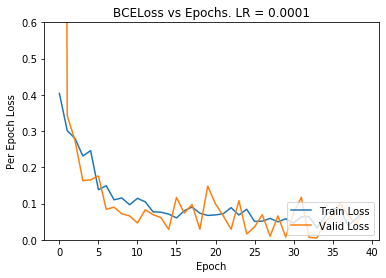

In [38]:
#Look at the train / validation loss 
plt.figure()
plt.plot(np.arange(0, EPOCHS, 1), epochLoss_train)
plt.plot(np.arange(0, EPOCHS, 1), epochLoss_valid)
plt.ylabel('Per Epoch Loss')
plt.xlabel('Epoch')
plt.title('BCELoss vs Epochs. LR = ' + str(lr))
plt.legend(['Train Loss', 'Valid Loss'], loc = "lower right")
plt.ylim([0,0.6])

plt.savefig(os.path.join(folder_path, 'Train-Val_Loss.png'))

In [45]:
#Only run this when the model has gone through training. 

del model #This removes any confliction with an existing model running on the GPU. 
model = smp.Unet(encoder_name = ENCODER, in_channels=1, classes = 1, aux_params = aux_params)
    
#read pickle
if 'pkl_location' not in locals():
    folder_path = '/home/mccrinbc/results_TBI_model-End-2020-10-05-11'
    pkl_location = "/home/mccrinbc/results_TBI_model-End-2020-10-05-11/results_TBI_model-End-2020-10-05-11.pkl"
print(pkl_location)

with open(pkl_location,'rb') as f:  
    brains, labels, predictions, single_class, loss_train, loss_valid, epochLoss_train, epochLoss_valid, test_dataset = pickle.load(f)

modelPath = model_locname
#modelPath = "/Users/brianmccrindle/Documents/Research/TBIFinder_Final/Registered_Brains_FA/models_saved/TBI_model-epoch2-2020-08-27-9-55.pt"
    
thresholds = np.arange(0,1.05,0.05) #skipping every other element, [[0.   0.05 0.1 ... 1]
#thresholds = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
TPR_list = [] #This is also known as RECALL. 
FPR_list = []
IoUs = []
Dice = []
total_error = []
precision = []

for threshold in thresholds:
    print(threshold)
    #test the model to capture performance. Reported in the Confusion Matrix values
    CM_values = testModel(test_dataset, modelPath, threshold) #tp, fn, fp, tn, [mean_IoUs]
    
    TPR = CM_values[0] / (CM_values[0] + CM_values[1])
    FPR = CM_values[2] / (CM_values[2] + CM_values[3])
    TPR_list.append(TPR)
    FPR_list.append(FPR)
    
    #IoUs, Dice, Total Error, and Precision. 
    IoUs.append(CM_values[0] / (CM_values[0] + CM_values[1] + CM_values[2]))  #IoU = TP / (TP + FN + FP)
    Dice.append(2 * CM_values[0] / (2 * CM_values[0] + CM_values[1] + CM_values[2])) #Dice = 2TP / (2TP + FN + FP)
    total_error.append(CM_values[1] + CM_values[2]) #Error = FP + FN. Weighted equally for now. 
    precision.append(CM_values[0] / (CM_values[0] + CM_values[2])) #Precision = TP / (TP + FP)

TPR_list = np.nan_to_num(TPR_list, nan = 0) #Replace any nans with 0.
FPR_list = np.nan_to_num(FPR_list, nan = 0) #Replace any nans with 0.
IoUs = np.nan_to_num(IoUs, nan = 0) #Replace any nans with 0. 
Dice = np.nan_to_num(Dice, nan = 0) #Replace any nans with 0. 
precision = np.nan_to_num(precision, nan = 0) #Replace any nans with 0.


#Within the same cell. Save the information from testing. 
difference_array = np.array(TPR_list) - (1-np.array(FPR_list))
best_acc_thresh = thresholds[abs(difference_array).argmin()] #Thresholds is already defined.  

best_IoU_thresh = thresholds[np.where(IoUs == np.max(IoUs))][0]
best_Dice_thresh = thresholds[np.where(Dice == np.max(Dice))][0]

results_name = 'ROC_AUC_results.pkl'
results_location = os.path.join(folder_path, results_name)

#This is saving the test results into a pkl file
with open(results_location, 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([TPR_list, FPR_list, precision, thresholds, best_acc_thresh, IoUs, Dice], f)

/home/mccrinbc/results_TBI_model-End-2020-10-05-18/results_TBI_model-End-2020-10-05-18.pkl
0.0


0it [00:00, ?it/s]../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
25it [00:30,  1.22s/it]


0.05


0it [00:00, ?it/s]../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
25it [00:30,  1.22s/it]


0.1


0it [00:00, ?it/s]../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
25it [00:30,  1.22s/it]


0.15000000000000002


0it [00:00, ?it/s]../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
25it [00:30,  1.21s/it]


0.2


0it [00:00, ?it/s]../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
25it [00:30,  1.22s/it]


0.25


0it [00:00, ?it/s]../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
25it [00:30,  1.20s/it]


0.30000000000000004


0it [00:00, ?it/s]../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
25it [00:30,  1.22s/it]


0.35000000000000003


0it [00:00, ?it/s]../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
25it [00:30,  1.22s/it]


0.4


0it [00:00, ?it/s]../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
25it [00:30,  1.21s/it]


0.45


0it [00:00, ?it/s]../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
25it [00:30,  1.22s/it]

0.5



0it [00:00, ?it/s]../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
25it [00:30,  1.20s/it]


0.55


0it [00:00, ?it/s]../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
25it [00:30,  1.22s/it]


0.6000000000000001


0it [00:00, ?it/s]../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
25it [00:30,  1.23s/it]


0.65


0it [00:00, ?it/s]../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
25it [00:30,  1.21s/it]


0.7000000000000001


0it [00:00, ?it/s]../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
25it [00:30,  1.23s/it]


0.75


0it [00:00, ?it/s]../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
25it [00:30,  1.21s/it]


0.8


0it [00:00, ?it/s]../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
25it [00:30,  1.23s/it]


0.8500000000000001


0it [00:00, ?it/s]../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
25it [00:30,  1.23s/it]


0.9


0it [00:00, ?it/s]../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
25it [00:30,  1.22s/it]


0.9500000000000001


0it [00:00, ?it/s]../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
25it [00:30,  1.21s/it]


1.0


0it [00:00, ?it/s]../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
25it [00:30,  1.22s/it]
<ipython-input-45-3a79e9c7d00d>:41: RuntimeWarning: invalid value encountered in double_scalars
  precision.append(CM_values[0] / (CM_values[0] + CM_values[2])) #Precision = TP / (TP + FP)


In [208]:
#This is saving the test results into a pkl file
#with open('ROC_AUC_results_better_metrics.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#    pickle.dump([TPR_list, FPR_list, precision, thresholds, best_acc_thresh, IoUs, Dice], f)

In [170]:
#If the best threshold is not a variable, we're probably missing info. 
#Load this into memory. 
with open('/home/mccrinbc/results_TBI_model-End-2020-10-05-11/ROC_AUC_results.pkl','rb') as f:  
    TPR_list, FPR_list, precision, thresholds, best_acc_thresh, IoUs, Dice = pickle.load(f)

In [53]:
base

'results_TBI_model-End-2020-10-05-18'

In [48]:
TPR_list = np.nan_to_num(TPR_list, nan = 0) #Replace any nans with 0.
FPR_list = np.nan_to_num(FPR_list, nan = 0) #Replace any nans with 0.
IoUs = np.nan_to_num(IoUs, nan = 0) #Replace any nans with 0. 
Dice = np.nan_to_num(Dice, nan = 0) #Replace any nans with 0. 
precision = np.nan_to_num(precision, nan = 0) #Replace any nans with 0.|

best_IoU_thresh = thresholds[np.where(IoUs == np.max(IoUs))][0]
best_Dice_thresh = thresholds[np.where(Dice == np.max(Dice))][0]

print(TPR_list)
print('')
print(FPR_list)

[1.         0.98210168 0.95403198 0.92604976 0.88892642 0.83793103
 0.77481065 0.68752536 0.6027817  0.52701879 0.45258986 0.33719842
 0.2549891  0.19534342 0.14592258 0.10018054 0.05885598 0.03013508
 0.01271787 0.0041016  0.        ]

[1.00000000e+00 9.37520364e-02 6.70162571e-02 5.30777753e-02
 4.02878239e-02 3.05583473e-02 2.27602113e-02 1.59875714e-02
 1.16266232e-02 8.70334618e-03 6.39772391e-03 3.78012970e-03
 2.29008444e-03 1.40035926e-03 8.24720017e-04 4.25281767e-04
 1.62671465e-04 4.77761548e-05 7.39896202e-06 4.22797830e-07
 0.00000000e+00]


40
Best Accuracy Threshold: 0.15000000000000002
Optimal Accuracy Sens: 0.9260497585937937
Optimal Accuracy Spec: 0.9469222247008745
40 0.35000000000000003 0.39625548100501784 0.35000000000000003 0.5675973865754067 0.15000000000000002 0.9260497585937937 0.9469222247008745
 
recall
[1.         0.98210168 0.95403198 0.92604976 0.88892642 0.83793103
 0.77481065 0.68752536 0.6027817  0.52701879 0.45258986 0.33719842
 0.2549891  0.19534342 0.14592258 0.10018054 0.05885598 0.03013508
 0.01271787 0.0041016  0.        ]
 
IoUs
[0.02128715 0.18493898 0.2337634  0.26917383 0.31165237 0.34841613
 0.37861402 0.39625548 0.39280585 0.37640136 0.3497208  0.28727128
 0.23069871 0.18352723 0.14059164 0.09825927 0.05841905 0.03006903
 0.01271354 0.00410152 0.        ]
 
Dice
[0.0416869  0.31214938 0.37894364 0.42417173 0.47520574 0.51677835
 0.54926762 0.56759739 0.56404969 0.54693546 0.51821207 0.44632594
 0.37490689 0.31013604 0.24652406 0.17893638 0.11038927 0.05838255
 0.02510787 0.00816953 0.       

Text(0.5, 1.0, 'Precision vs Recall')

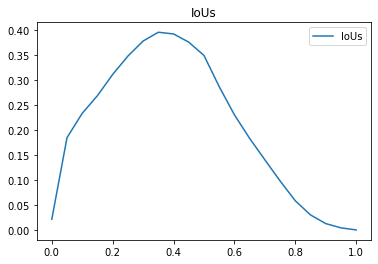

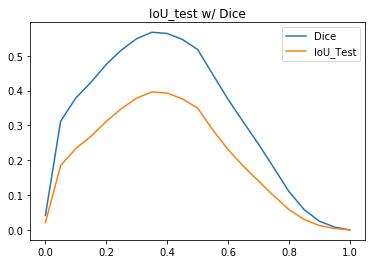

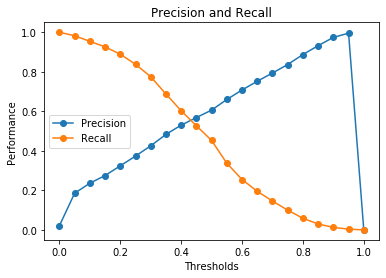

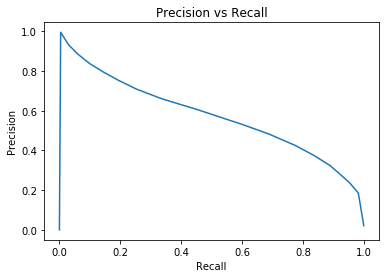

In [49]:
#NOTE: 
#I have implemented a custom IoU functon that determines the MEAN IoU, which includes the background IoU
#This is a heavily biased metric, and I think it makes the model seem better than it is. 
#Heavy class imbalance at the edges of the image due to padding causes the MeanIoU to skyrocket (~double reg IoU)
#IoU from sklearn is probably better. 

#Total Error metric does not seem very informative. 
difference_array = np.array(TPR_list) - (1-np.array(FPR_list))
#Utility to Plot Relavent Information 
print(EPOCHS)
#print('Best IoU Threshold',best_IoU_thresh)
print('Best Accuracy Threshold:', best_acc_thresh)

sens = TPR_list[abs(difference_array).argmin()]
spec = 1 - FPR_list[abs(difference_array).argmin()]

print('Optimal Accuracy Sens:', sens)
print('Optimal Accuracy Spec:', spec)

#copy this over into excel, split with , delimiter. 
print(EPOCHS,best_IoU_thresh,np.max(IoUs),best_Dice_thresh,np.max(Dice),best_acc_thresh,sens,spec)

print(' ')
print('recall')
print(TPR_list)

print(' ')
print('IoUs')
print(IoUs)
print(' ')
print('Dice')
print(Dice)

print(' ')
print('precision')
print(precision)

print(' ')
print('recall')
print(TPR_list)

plt.figure(1)
plt.plot(thresholds,IoUs)
plt.title("IoUs")
plt.legend(['IoUs'])

plt.figure(2)
plt.plot(thresholds,Dice)
plt.plot(thresholds,IoUs)
plt.title("IoU_test w/ Dice")
plt.legend(['Dice', 'IoU_Test'])

plt.figure(4)
plt.plot(thresholds, precision, '-o')
plt.plot(thresholds, TPR_list, '-o')
plt.title('Precision and Recall')
plt.xlabel('Thresholds')
plt.ylabel('Performance')
plt.legend(['Precision','Recall'])

#Quarter-circle type curve
plt.figure(5)
plt.plot(TPR_list, precision)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision vs Recall')


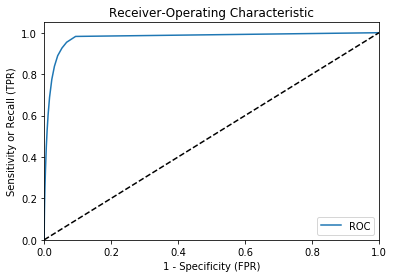

In [50]:
#Plot the ROC curve and determine the optimal cut-off threshold point
#evaluateModel.ROC_AUC(FPR_list, TPR_list)

#Will look good because majority of model are zeros. 

from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,1)
ax.plot(FPR_list, TPR_list)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('1 - Specificity (FPR)')
ax.set_ylabel('Sensitivity or Recall (TPR)')
ax.set_title('Receiver-Operating Characteristic')
ax.legend(['ROC'],loc = "lower right")

In [192]:
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [93]:
#This section is made to analyze how well the model performed overall. 
del model
model = smp.Unet(encoder_name = ENCODER, in_channels=1, classes = 1, aux_params = aux_params)
modelPath = "/home/mccrinbc/results_TBI_model-End-2020-10-05-11/results_TBI_model-End-2020-10-05-11.pt"
model.load_state_dict(torch.load(modelPath))
model.eval() #put into evaluation mode
model.to(torch.device('cpu'))
    
#These need to be the results correspodning to the model you're loading. 
with open('/home/mccrinbc/results_TBI_model-End-2020-10-05-11/results_TBI_model-End-2020-10-05-11.pkl','rb') as f:  
    brains, labels, predictions, single_class, loss_train, loss_valid, epochLoss_train, epochLoss_valid, test_dataset = pickle.load(f)

loader = DataLoader(test_dataset, batch_size = 1, shuffle = False, num_workers = num_workers)

#data is called from the loader as loader.dataset[image-label_number][0 OR 1] (shape: [1,256,256])

In [94]:
print(test_dataset.transform)

Compose(
    RandomAffine(degrees=(0, 0), scale=[1, 1])
    RandomHorizontalFlip(p=0)
    Pad(padding=37, fill=0, padding_mode=constant)
    ToTensor()
)


In [95]:
def load_image_result(loader, index, model, threshold):
    #The model expects there to be a batch of images. Need to specify a single image in batch. 
    
    brain = loader.dataset[index][0].unsqueeze(0) #index brain/label, get brain only, compress to only 2D
    label = loader.dataset[index][1][0]
    
    predictions, _ = model(brain)
    predictions = torch.sigmoid(predictions)
    thresh_prediction = predictions > threshold
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,15))
    #fig.suptitle('Brain, True Label, Prediction')
    ax1.imshow(brain[0][0].detach().numpy())
    ax2.imshow(label.detach().numpy())
    ax3.imshow(predictions[0][0].detach().numpy() > threshold)
    
    mean_IoU = IoU(thresh_prediction, label)
    print("IoU: ", mean_IoU)
    
    return thresh_prediction

IoU:  0.0


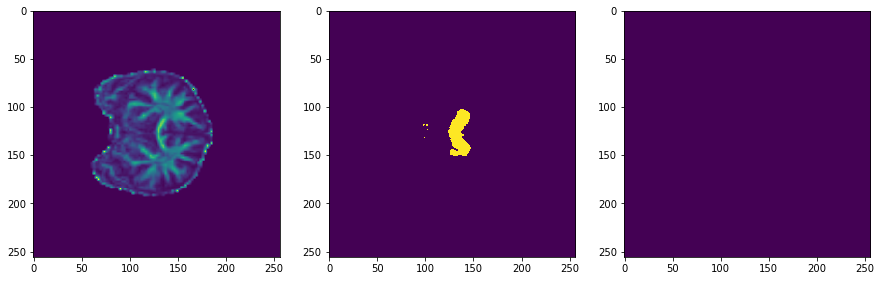

In [97]:
thresh_prediction = load_image_result(loader, 30, model, 0.5) #Takes a second to run if on CPU. 

#non-deterministic behaviour might be occuring because of the transform function explicity built into the
#dataset call above. Potentially retrain and remove transform from testing dataset. 

#Each call of loader.dataset could be passing in the FIRST image you expect through a set of RANDOM transformations
#This would make sense as to why we're getting randomness. 

In [127]:
predictions[0,0,:,:]

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

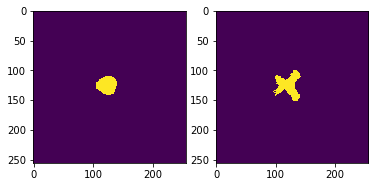

In [132]:
#Load the brains, Determine the Predictions, Threshold the prediction with optimal value, plot

image_loc = 0
brains, labels = loader.dataset[2] #Pick batches you'd like to see. Must be <= batch_total

brains = brains.unsqueeze(0)
labels = labels.unsqueeze(0)

predictions, _ = model(brains)
predictions = torch.sigmoid(predictions)

predictions = predictions > 0.20 #not sure if this is going to work with a batch of images. 

plt.subplot(1,2,1)
plt.imshow(predictions[image_loc,0,:,:])
plt.subplot(1,2,2)
plt.imshow(labels[image_loc,0,:,:])

In [150]:
CM = sklearn.metrics.confusion_matrix(labels.numpy().ravel() ,predictions.numpy().ravel() ,labels = [True,False])
print(CM)

[[  675   514]
 [  185 64162]]


In [151]:
a = sklearn.metrics.confusion_matrix([True, False, False, True], [True, True, True, False], labels = [True,False])

In [152]:
prediction, label = torch.zeros(10,10), torch.zeros(10,10)

In [258]:
label[2:4,3:9] = 1
prediction[3:5,2:6] = 1

In [259]:
print(label)
print('')
print(prediction)
print('')
print(prediction + label)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]

In [260]:
test =  sklearn.metrics.confusion_matrix(label.numpy().ravel(),prediction.numpy().ravel() > 0, labels = [True,False])

In [261]:
test

array([[ 3,  9],
       [ 5, 83]])

In [262]:
IoU = test[0][0] / (test[0][0] + test[0][1] + test[1][0])
print(IoU)

prediction = prediction > 0
label = label > 0
print(prediction.shape)
intersection = int(torch.sum(torch.mul(prediction,label)))
#mean_IoU = IoU(prediction > 0, label > 0)

0.17647058823529413
torch.Size([10, 10])


In [263]:
    #Good
    intersection = int(torch.sum(torch.mul(prediction,label)))
    union = int(torch.sum(prediction) + torch.sum(label)) - intersection
    IOU_predicted = intersection / (union + 0.0001) #for stability
    print(IOU_predicted)

0.17646955017911659


In [264]:
    #Background IoU
    all_zeros = (prediction + label) > 0 #before the inversion
    intersection = int(torch.sum(~all_zeros))
    union = int(torch.sum(~ (prediction > 0)) + torch.sum(~ (label > 0)) - intersection)
    IOU_background = intersection / (union + 0.0001)
    
    mean_IOU = (IOU_background + IOU_predicted)/2
    print(mean_IOU)

0.5160693855693412


In [213]:
prediction

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [215]:
y_pred = predictions[:, 0].contiguous().view(-1)

In [255]:
weight = torch.tensor([0.1, 0.9])
weight_ = weight[predictions.data.view(-1).long()].view_as(predictions)

In [257]:
weight

tensor([0.1000, 0.9000])

In [277]:
label = torch.zeros(3,1,10,10)
label[0,0,2:4,3:9] = 1
label[1,0,1:7,3:] = 1
label[2,0,5:7,1:3] = 1
print(label)

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 1., 1., 1., 1., 1., 0.],
          [0., 0., 0., 1., 1., 1., 1., 1., 1., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
          [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
          [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
          [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
          [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
          [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        

In [282]:
weights,pos_weight,neg_weight = Weights(labels)
weight =  torch.rand (labels.shape)
print(weight.shape)

torch.Size([1, 1, 256, 256])


In [306]:
label
weights,pos_weight,neg_weight  = Weights(label)

In [318]:
def Weights(labels):
    #expects an [batch_size,c,n,n] input 
    
    weights = torch.rand(labels.shape) #create a random tensor of weight values. 
    for batch_num in range(0,labels.shape[0]):
        num_ones = torch.sum(labels[batch_num,0,:,:]);
        resolution = labels.shape[2] * labels.shape[3]
        num_zeros = resolution - num_ones 
        
        #https://discuss.pytorch.org/t/how-to-apply-a-weighted-bce-loss-to-an-imbalanced-dataset-what-will-the-weight-tensor-contain/56823/2
        #Weight for the positive class
        pos_weight = num_zeros / resolution #should be close to 1.
        neg_weight = 1 - pos_weight 
        
        weights[batch_num,0,:,:] = torch.ones(labels.shape[2],labels.shape[3])*neg_weight + labels[batch_num,0,:,:]*pos_weight
        
    #this keeps the clas imbalance in check
    return weights,pos_weight,neg_weight #should be a tensor. 

In [319]:
weights,pos_weight,neg_weight  = Weights(label)
print(weights[0,0,:,:])
print('')
print(label[0,0,:,:])

tensor([[0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200,
         0.1200],
        [0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200,
         0.1200],
        [0.1200, 0.1200, 0.1200, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         0.1200],
        [0.1200, 0.1200, 0.1200, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         0.1200],
        [0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200,
         0.1200],
        [0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200,
         0.1200],
        [0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200,
         0.1200],
        [0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200,
         0.1200],
        [0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200,
         0.1200],
        [0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200,
         0.1200]])

tensor([

In [317]:
label[0,0,:,:]*neg_weight

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]])

In [320]:
predict = torch.rand ((1, 1, 60, 40, 40))
target = torch.bernoulli (predict)
weight =  torch.rand ((1, 1, 60, 40, 40))

weight_rebal = torch.ones_like (target) / 95.0  +  (1.0 - 1.0 / 95.0) * target

In [321]:
weight_rebal

tensor([[[[[0.0105, 0.0105, 1.0000,  ..., 1.0000, 0.0105, 1.0000],
           [1.0000, 0.0105, 0.0105,  ..., 0.0105, 1.0000, 1.0000],
           [1.0000, 0.0105, 1.0000,  ..., 1.0000, 0.0105, 0.0105],
           ...,
           [0.0105, 0.0105, 1.0000,  ..., 1.0000, 0.0105, 0.0105],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.0105],
           [0.0105, 1.0000, 1.0000,  ..., 1.0000, 0.0105, 0.0105]],

          [[1.0000, 0.0105, 1.0000,  ..., 1.0000, 0.0105, 1.0000],
           [1.0000, 0.0105, 0.0105,  ..., 0.0105, 1.0000, 0.0105],
           [0.0105, 0.0105, 0.0105,  ..., 0.0105, 0.0105, 0.0105],
           ...,
           [0.0105, 1.0000, 0.0105,  ..., 0.0105, 1.0000, 0.0105],
           [0.0105, 0.0105, 0.0105,  ..., 0.0105, 1.0000, 0.0105],
           [0.0105, 1.0000, 0.0105,  ..., 0.0105, 1.0000, 0.0105]],

          [[0.0105, 0.0105, 0.0105,  ..., 1.0000, 0.0105, 0.0105],
           [0.0105, 1.0000, 0.0105,  ..., 1.0000, 0.0105, 0.0105],
           [0.0105, 0.0105

In [343]:
a.device

device(type='cpu')

In [344]:
a = 1
a.device()

AttributeError: 'int' object has no attribute 'device'